## Task A: optimize a region

In [29]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import pypsa 
import warnings
import os
import sys
import contextlib
warnings.filterwarnings("ignore")

# Function to reduce console print of optimizer
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as fnull:
        old_stdout = sys.stdout
        sys.stdout = fnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# Import datasets for region and year of interest
country = "FIN"
year = 2015

demand_all = pd.read_csv("electricity_demand.csv", sep=";", index_col=0, parse_dates=True )
demand_all.index = demand_all.index.tz_localize(None)
demand = demand_all[country].loc[demand_all.index.year == year]

onshore_all = pd.read_csv("onshore_wind_1979-2017.csv", sep=";", index_col=0, parse_dates=True)
onshore_all.index = onshore_all.index.tz_localize(None)
onshore_all = onshore_all[~((onshore_all.index.month == 2) & (onshore_all.index.day == 29))] # Remove leap day
onshore_2015 = onshore_all[country].loc[onshore_all.index.year == year]

solar_all = pd.read_csv("pv_optimal.csv", sep=";", index_col=0, parse_dates=True)
solar_all.index = solar_all.index.tz_localize(None)
solar_all = solar_all[~((solar_all.index.month == 2) & (solar_all.index.day == 29))] # Remove leap day
solar_2015 = solar_all[country].loc[solar_all.index.year == year]

heat_all = pd.read_csv("heat_demand.csv", sep=";", index_col=0, parse_dates=True)
heat_all.index = heat_all.index.tz_localize(None)
heat = heat_all[country].loc[solar_2015.index.year == year]

# Import hydro data
hydro_all = pd.read_csv("hydro.csv", sep=";", index_col=0, parse_dates=True)
hydro_all = hydro_all["Hydro power production - real time data"]
hydro_all.index = hydro_all.index.tz_localize(None)
hydro_all = hydro_all.resample("H").mean()/3100 # Estimate capacity factor based on current installed capacity of 3.1 GW
hydro_all = hydro_all.fillna(method="ffill") # Fill NaN with previous value
hydro_all = hydro_all[~((hydro_all.index.month == 2) & (hydro_all.index.day == 29))] # Remove leap day
hydro_2015 = hydro_all.loc[hydro_all.index.year == year]

# Extend hydro data to cover the entire period of interest
start_target = pd.Timestamp('1979-01-01 00:00')
end_target = pd.Timestamp('2017-12-31 23:00')
num_repeats = 11
hydro_extended = pd.concat([hydro_all.copy() for _ in range(num_repeats)], axis=0)
hydro_extended.index = pd.date_range(start=start_target, periods=len(hydro_extended), freq='H')

# Remove leap day
hydro_extended = hydro_extended[~((hydro_extended.index.month == 2) & (hydro_extended.index.day == 29))] # Remove leap day
# Keep only data within the target range
hydro_extended = hydro_extended[(hydro_extended.index >= start_target) & (hydro_extended.index <= end_target)]

# Get snapshots for the year of interest
snapshots = demand.index


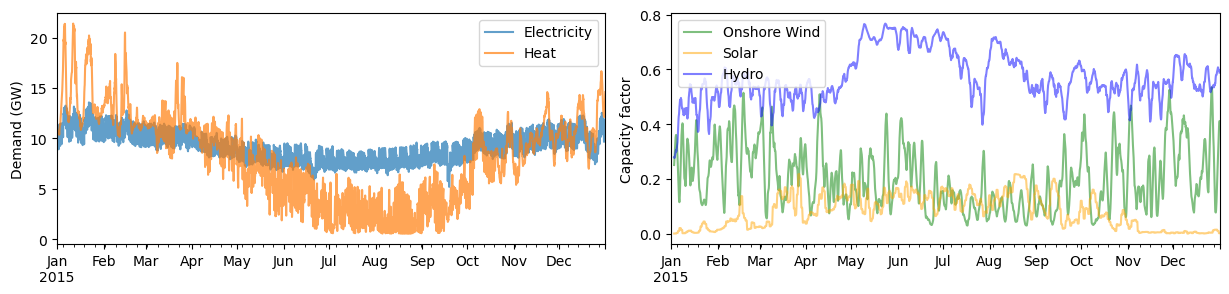

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3), sharex=True)
demand.div(1e3).plot(label="Electricity", alpha = 0.7, ax = ax[0])
heat.div(1e3).plot(label="Heat", alpha = 0.7, ax = ax[0])
ax[0].legend()
ax[0].set_ylabel("Demand (GW)")
ax[0].set_xlabel("")


window = 48
onshore_2015.rolling(window).mean().plot(label="Onshore Wind", color="green", alpha=0.5, ax=ax[1])
solar_2015.rolling(window).mean().plot(label="Solar", color="orange", alpha=0.5, ax=ax[1])
hydro_2015.rolling(window).mean().plot(label="Hydro", color="blue", alpha=0.5, ax=ax[1])
ax[1].set_ylabel("Capacity factor")
ax[1].set_xlabel("")
ax[1].legend(loc = "upper left")

plt.subplots_adjust(wspace=0.12, hspace=0.3)
plt.show()

In [31]:
# Annuity function for converging capital costs to annualized costs
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

# Import costs from PyPSA technology data
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_2030.csv"
costs = pd.read_csv(url, index_col=[0, 1])

# Convert cost units to MW
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

# Define default values for missing parameters 
defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}

costs = costs.value.unstack().fillna(defaults)

# Set OCGT cost and emissions to gas values
costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

# Set OCGT cost and emissions to gas values
costs.at["biomass CHP", "CO2 intensity"] = costs.at["solid biomass", "CO2 intensity"]
costs.at["biomass CHP", "fuel"] = costs.at["solid biomass", "fuel"]

# Compute marginal costs
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

# Compute capital costs
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

In [32]:
# Create a PyPSA network
network = pypsa.Network()
network.set_snapshots(snapshots.values)

# Add electricity bus
network.add("Bus", "FIN_el")

# Add carriers
carriers = [
    "onwind",
    "solar",
    "OCGT",
    "nuclear",
    "biomass CHP",
    "coal",
    "hydro",

]

colors = ["dodgerblue", "gold", "brown", "blue", "green", "orange", "red", "purple"]

# Add carriers to the network with CO2 emissions and colors
for i, carrier in enumerate(carriers):
    network.add("Carrier", carrier, co2_emissions=costs.at[carrier, "CO2 intensity"], color=colors[i])

# Define capacity factors for each carrier
CF = pd.DataFrame(1, index=snapshots, columns=carriers)
CF = CF.assign(onwind=onshore_2015.values, solar=solar_2015.values, hydro=hydro_2015.values )

# Add electricity load
network.add("Load", "el_load", bus="FIN_el", p_set=demand.values)

# Add generators
for carrier in carriers:
        network.add("Generator", carrier, bus="FIN_el", p_nom_extendable=True, 
                    p_max_pu      = CF[carrier].values,
                    marginal_cost = costs.at[carrier, "marginal_cost"], 
                    efficiency    = costs.at[carrier, "efficiency"], 
                    capital_cost  = costs.at[carrier, "capital_cost"], 
                    carrier       = carrier
        )

# Limit the capacity of hydro
network.generators.loc["hydro", "p_nom_max"] = 3100 # MW


# Optimize with reduced output
# Suppress the solver output by using the context manager
with suppress_stdout():
    network.optimize(solver_name='gurobi', solver_options={'outputflag': 0})

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 13.79it/s]
INFO:linopy.io: Writing time: 0.88s
INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-2ppg7irj.lp
INFO:gurobipy:Reading time = 0.25 seconds
INFO:gurobipy:obj: 131408 rows, 61327 columns, 241259 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131408 duals
Objective: 5.25e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


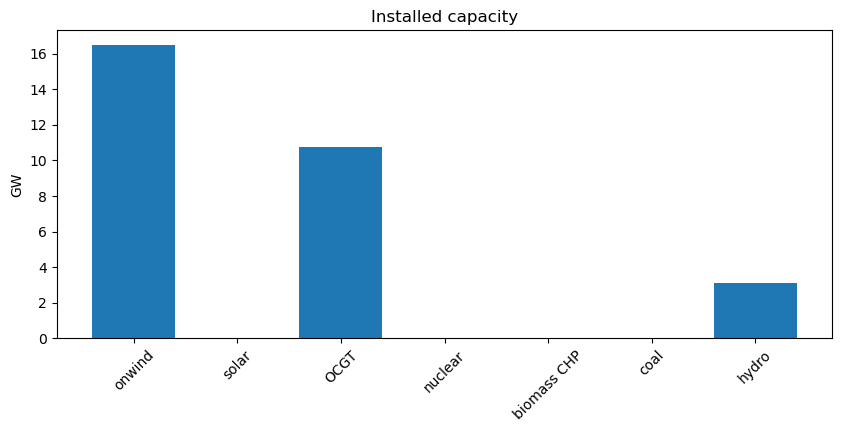

In [33]:
# Extract results
gen_cap = network.generators.p_nom_opt
gen_prod = network.generators_t.p

# Plotting the resulting capacity
fig, ax = plt.subplots(1, 1, figsize=(10,4), sharey=True)
ax.bar(gen_cap.index, gen_cap.values/1E3)
ax.set_xticks(ticks = gen_cap.index, labels = gen_cap.index, rotation=45)
ax.set_title("Installed capacity")
ax.set_ylabel("GW")
plt.show()

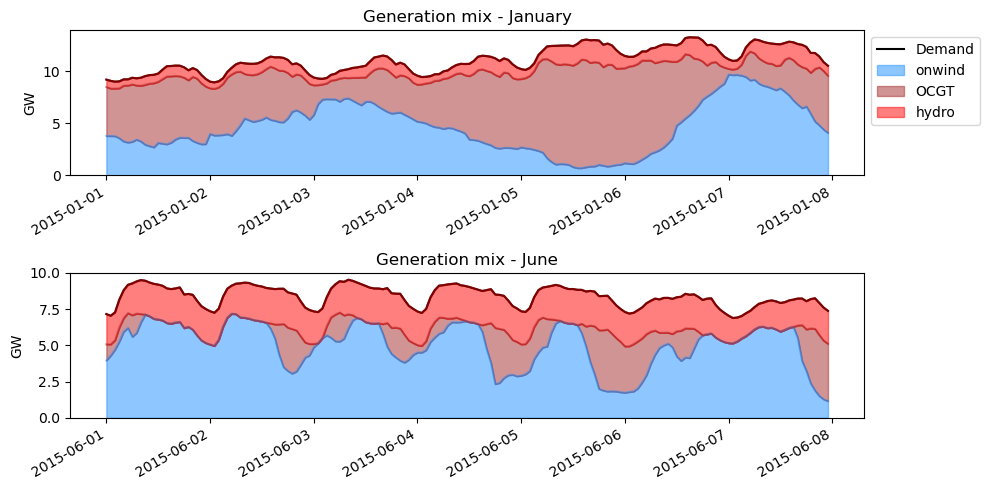

In [34]:
# Plot a week of generation
start_date_jan = "2015-01-01"
end_date_jan = "2015-01-7"
start_date_jun = "2015-06-01"
end_date_jun = "2015-06-7"

demand_jan = demand.loc[start_date_jan:end_date_jan].div(1e3) # Convert to GW
generator_jan = gen_prod.loc[start_date_jan:end_date_jan,  (gen_prod != 0).any(axis=0)].div(1e3)

demand_jun = demand.loc[start_date_jun:end_date_jun, ].div(1e3)
generator_jun = gen_prod.loc[start_date_jun:end_date_jun, (gen_prod != 0).any(axis=0)].div(1e3)


fig, ax = plt.subplots(2, 1, figsize=(10,5))
ax[0].plot(demand_jan.index, demand_jan.values, label="Demand", color="black")
generator_jan.plot.area(ax=ax[0], alpha=0.5, stacked=True, color=generator_jan.columns.map(network.carriers.color), legend=True)
ax[0].set_title("Generation mix - January")
ax[0].set_ylabel("GW")
ax[0].set_xlabel("")
ax[0].legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)

ax[1].plot(demand_jun.index, demand_jun.values, label="Demand", color="black")
generator_jun.plot.area(ax=ax[1], alpha=0.5, stacked=True, color=generator_jan.columns.map(network.carriers.color), legend=False)
ax[1].set_title("Generation mix - June")
ax[1].set_ylabel("GW")
ax[1].set_xlabel("")

plt.subplots_adjust(hspace=0.5, bottom=0.1, right=0.95, top=0.9)
plt.tight_layout()
plt.show()

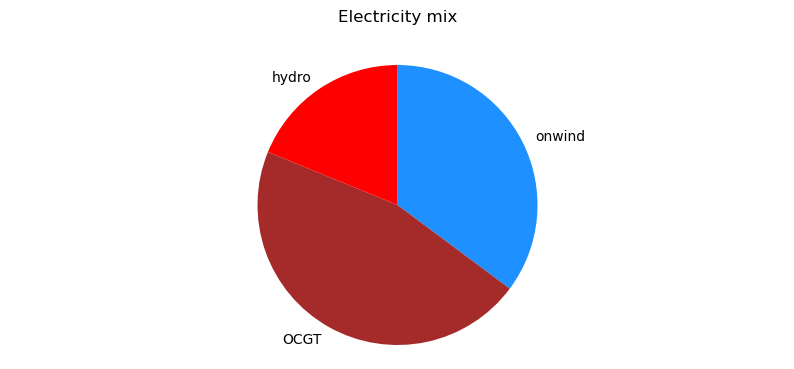

In [35]:
# Plot electricity mix
energy_production = network.generators_t.p
energy_sum = energy_production.sum(axis=0)
energy_sum = energy_sum[energy_sum != 0]

fig, ax = plt.subplots(1, 1, figsize=(10,4), sharey=True)
plt.pie(energy_sum.values, labels=energy_sum.index, colors=energy_sum.index.map(network.carriers.color), startangle=90, counterclock=False);
plt.axis('equal')
plt.title('Electricity mix', y=1.07)
plt.show()

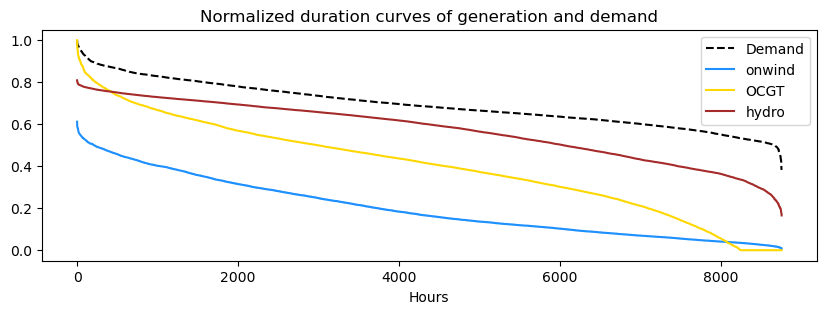

In [36]:
# Plot duration curves of generation and demand
fig, ax = plt.subplots(1, 1, figsize=(10,3))
ax.plot((demand/max(demand)).sort_values(ascending=False).reset_index(drop=True), label="Demand", color="black", linestyle="--")

for i, col in enumerate(energy_sum.index):
    ax.plot((energy_production[col]/gen_cap[col]).sort_values(ascending=False).reset_index(drop=True), label=col, color=colors[i])

plt.legend()
plt.title("Normalized duration curves of generation and demand")
plt.xlabel("Hours")
plt.show()

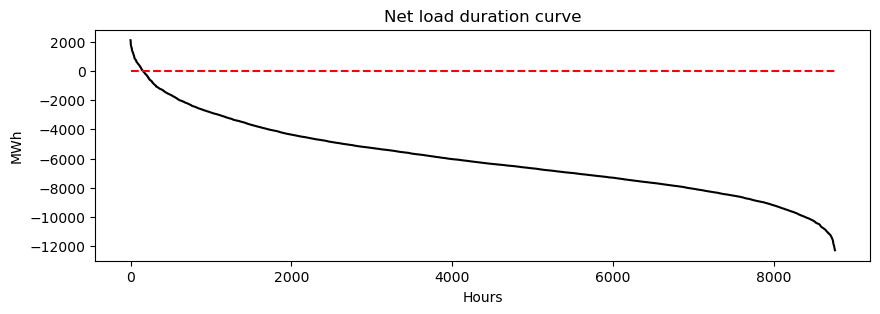

In [37]:
# Plot net load duration curve
fig, ax = plt.subplots(1, 1, figsize=(10,3))

net_load = (gen_cap * CF)["onwind"] - demand
net_load.sort_values(ascending=False).reset_index(drop=True).plot(color="black")
plt.title("Net load duration curve")
plt.xlabel("Hours")
plt.ylabel("MWh")
plt.hlines(0, 0, len(net_load), color="red", linestyle="--")
plt.show()

## B: CO2 limits

In [38]:
# Add a CO2 limit constraint, for now a dummy value
network.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=119E5, #11.9MtCO2
    type="primary_energy",
)

In [39]:
# Prepare for sensitivity analysis
sensitivity_cost = {}
sensitivity_capacity = {}
sensitivity_production = {}
co2_price = {}

# Compute the total system cost (capital + operational) for the current network
def system_cost(n):
    tsc = n.statistics.capex() + n.statistics.opex()
    return tsc.droplevel(0).div(1e6)  # million €/a

# Define the CO2 limits for sensitivity analysis and run the optimization for each limit
# co2Limits = [30, 25, 20, 15, 11.9, 8, 6.23, 3, 1.5, 0.5]
co2Limits = [30, 25, 20, 15, 11.9, 8, 6.23, 3, 2, 1, 0]
for co2 in co2Limits:
    network.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6 # MtCO2/a
    
    with suppress_stdout(): # Reduce output
        network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

    
    sensitivity_cost[co2] = system_cost(network)
    sensitivity_capacity[co2] = network.generators.p_nom_opt.copy()
    sensitivity_production[co2] = network.generators_t.p.sum(axis=0)
    co2_price[co2] = -network.global_constraints.mu['CO2Limit']

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 17.22it/s]
INFO:linopy.io: Writing time: 0.9s
INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-jp630jz1.lp
INFO:gurobipy:Reading time = 0.27 seconds
INFO:gurobipy:obj: 131409 rows, 61327 columns, 267539 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131409 duals
Objective: 5.25e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver o

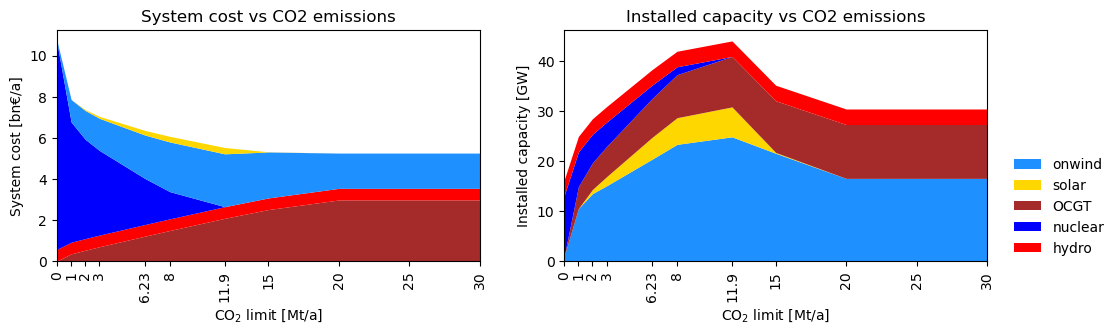

In [40]:
sens_cost = pd.DataFrame(sensitivity_cost).T.div(1e3)  # billion Euro/a
sens_cap = pd.DataFrame(sensitivity_capacity).T.div(1e3)  # GW
sens_prod = pd.DataFrame(sensitivity_production).T.div(1e3)  # GWh/a

# Include only technologies that are used in the network
sens_cost = sens_cost.loc[:, sens_cost.sum() != 0]
sens_cap = sens_cap.loc[:, sens_cap.sum() != 0]

fix, ax = plt.subplots(1,2, figsize=(12,3))
# Plot system cost vs CO2 emissions
sens_cost.plot.area(
    ax = ax[0],
    stacked=True, linewidth=0,
    color=sens_cost.columns.map(network.carriers.color),
    xlim=(min(co2Limits), max(co2Limits)),
    xlabel=r"CO$_2$ limit [Mt/a]",
    ylabel="System cost [bn€/a]",
    title="System cost vs CO2 emissions",
)
ax[0].set_xticks(co2Limits, co2Limits, rotation=90)
ax[0].get_legend().remove()

sens_cap.plot.area(ax = ax[1], 
                  stacked = True, linewidth=0,
                  color = sens_cap.columns.map(network.carriers.color),
                  xlim=(min(co2Limits), max(co2Limits)),
                  xlabel=r"CO$_2$ limit [Mt/a]",
                  ylabel="Installed capacity [GW]",
                  title="Installed capacity vs CO2 emissions",
)

ax[1].set_xticks(co2Limits, co2Limits, rotation=90)
ax[1].legend(frameon=False, loc=(1.05, 0))
plt.show()

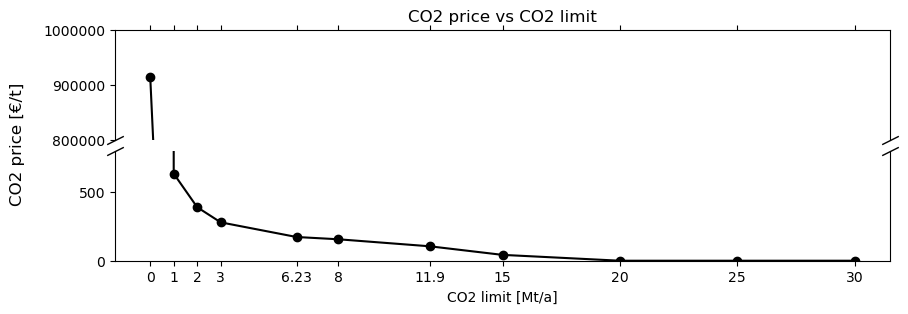

In [41]:
# Plot CO2 price vs CO2 limit
import matplotlib.ticker as ticker

fig, ax = plt.subplots(2, 1, figsize=(10, 3), sharex=True)
fig.subplots_adjust(hspace=0.1)  
ax[0].plot(co2Limits, co2_price.values(), marker="o", color="black")
ax[1].plot(co2Limits, co2_price.values(), marker="o", color="black")

ax[0].set_ylim(800000, 1000000)  # outliers only
ax[1].set_ylim(0, 800)  # most of the data


ax[0].spines.bottom.set_visible(False)
ax[1].spines.top.set_visible(False)
ax[0].xaxis.tick_top()
ax[0].tick_params(labeltop=False)  # don't put tick labels at the top
ax[1].xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)

formatter = ticker.ScalarFormatter(useOffset=False, useMathText=False)
formatter.set_scientific(False)
ax[0].yaxis.set_major_formatter(formatter)
ax[1].yaxis.set_major_formatter(formatter)

ax[1].set_xticks(co2Limits, co2Limits)
ax[1].set_xlabel("CO2 limit [Mt/a]")
fig.supylabel('CO2 price [€/t]')

ax[0].set_title("CO2 price vs CO2 limit")
plt.show()

## C: new weather

In [42]:
weather_years = np.arange(1979, 2018)

sensitivity_cost = {}
sensitivity_capacity = {}
sensitivity_production = {}

# Fix CO2 limit
network.global_constraints.loc["CO2Limit", "constant"] = 3 * 1e6 # MtCO2/a

for year in weather_years:
    onshore = onshore_all.loc[onshore_all.index.year == year, country]
    solar = solar_all.loc[solar_all.index.year == year, country]
    hydro = hydro_extended.loc[hydro_extended.index.year == year]

    # Update model
    network.generators_t["p_max_pu"] = network.generators_t["p_max_pu"].assign(
                                       onwind=onshore.values,
                                       solar=solar.values,
                                       hydro=hydro.values)

    with suppress_stdout(): # Reduce output
        network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})


    sensitivity_cost[year] = system_cost(network)
    sensitivity_capacity[year] = network.generators.p_nom_opt.copy()
    sensitivity_production[year] = network.generators_t.p.copy()

sens_cost = pd.DataFrame(sensitivity_cost).T.div(1e3)  # billion Euro/a
sens_cap = pd.DataFrame(sensitivity_capacity).T.div(1e3) # GW

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 16.92it/s]
INFO:linopy.io: Writing time: 0.92s
INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-am1_trb4.lp
INFO:gurobipy:Reading time = 0.28 seconds
INFO:gurobipy:obj: 131409 rows, 61327 columns, 267571 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131409 duals
Objective: 7.63e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver 

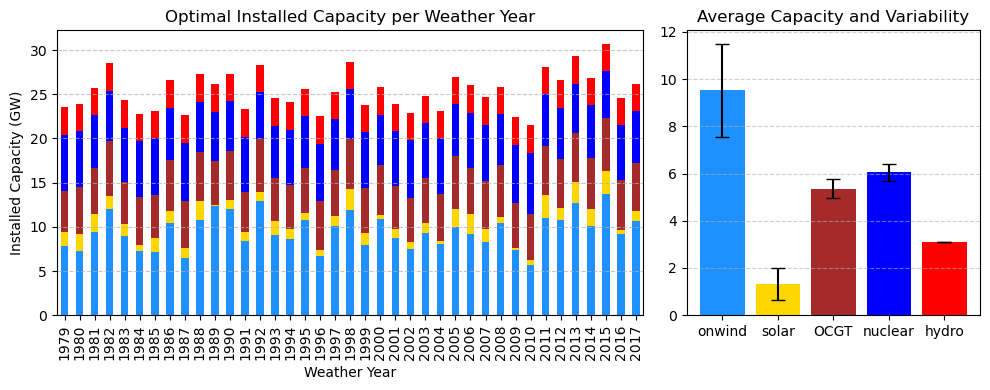

yearly generation statistics:
Generator     onwind      solar       OCGT    nuclear         hydro
count      39.000000  39.000000  39.000000  39.000000  3.900000e+01
mean        9.527525   1.319222   5.352720   6.043679  3.100000e+00
std         1.961350   0.667706   0.400101   0.372340  2.249473e-15
min         5.690694   0.121763   4.547755   5.320083  3.100000e+00
25%         8.046694   0.850582   5.075564   5.778609  3.100000e+00
50%         9.269656   1.189180   5.349983   6.027681  3.100000e+00
75%        10.798013   1.750321   5.640102   6.328151  3.100000e+00
max        13.750218   2.655085   6.265090   6.884970  3.100000e+00
Yearly cost statistics:
count    39.000000
mean      7.486058
std       0.132997
min       7.178897
25%       7.399205
50%       7.488309
75%       7.576205
max       7.788349
dtype: float64


In [43]:
color=sens_cost.columns.map(network.carriers.color)
# Clean sens_cap: remove columns with very small capacity
sens_cap_clean = sens_cap.loc[:, sens_cap.max() > 0.1]

# Only plot the carriers present in sens_cap
present_carriers = sens_cap_clean.columns

# Map the correct colors from network.carriers.color
plot_colors = present_carriers.map(network.carriers.color)

# Calculate average and standard deviation
mean_cap = sens_cap_clean.mean(axis=0)
std_cap = sens_cap_clean.std(axis=0)

fig, ax = plt.subplots(1,2, figsize=(10,4), gridspec_kw={'width_ratios': [2, 1]})

sens_cap_clean.plot(
    kind="bar",
    stacked=True,
    color=plot_colors,
    ax = ax[0])
ax[0].set_title("Optimal Installed Capacity per Weather Year")
ax[0].set_xlabel("Weather Year")
ax[0].set_ylabel("Installed Capacity (GW)")
# ax[0].legend(title="Technology", bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].get_legend().remove()
ax[0].grid(axis="y", linestyle="--", alpha=0.7)


ax[1].bar(mean_cap.index, mean_cap.values, 
        yerr=[std_cap.values, std_cap.values], 
        capsize=5, 
        color=mean_cap.index.map(network.carriers.color))
# ax[1].set_ylabel("Installed Capacity (GW)")
ax[1].set_title("Average Capacity and Variability")
ax[1].grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("yearly generation statistics:")
print(sens_cap_clean.describe())

print("Yearly cost statistics:")
yearly_cost = sens_cost.sum(axis=1)
print(yearly_cost.describe())

## D: Add storage

In [44]:
# Reset basis year to 2015
year = 2015
network.global_constraints.loc["CO2Limit", "constant"] = co2 * 3e6 # MtCO2/a

onshore = onshore_all[country].loc[onshore_all.index.year == year]
solar = solar_all[country].loc[solar_all.index.year == year]
hydro = hydro_extended.loc[hydro_extended.index.year == year]

# Update model
network.generators_t["p_max_pu"] = network.generators_t["p_max_pu"].assign(
                                       onwind=onshore.values, solar=solar.values, hydro=hydro.values)

# Add storage bus
network.add("Carrier", "battery storage", co2_emissions=0, color="purple")
carriers.append("battery storage")

network.add(
    "StorageUnit",
    "battery storage",
    bus="FIN_el",
    carrier="battery storage",
    max_hours=2,
    capital_cost=costs.at["battery inverter", "capital_cost"]
    + 2 * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
    overwrite=True,
)


# Optimize with reduced output
with suppress_stdout():
    network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 32.76it/s]
INFO:linopy.io: Writing time: 1.58s
INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-4uwt4ml_.lp
INFO:gurobipy:Reading time = 0.42 seconds
INFO:gurobipy:obj: 192730 rows, 87608 columns, 398940 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87608 primals, 192730 duals
Objective: 1.00e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-

Text(0, 0.5, 'State of Charge (MWh)')

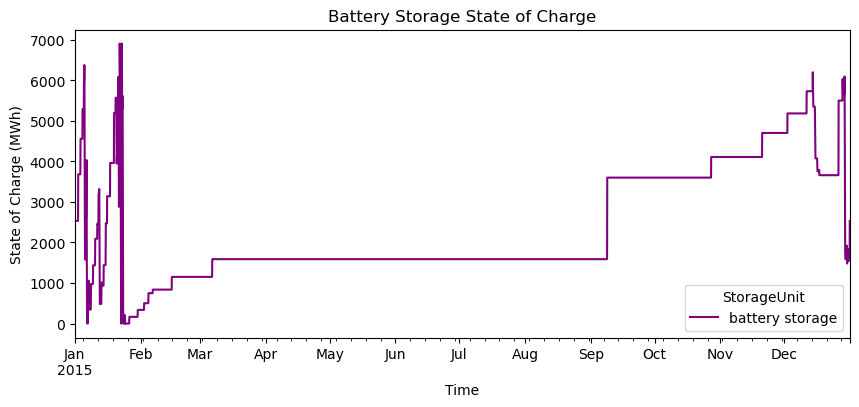

In [45]:
# plot battery storage
network.storage_units_t.state_of_charge.plot(figsize=(10, 4), color="purple")
plt.title("Battery Storage State of Charge")
plt.xlabel("Time")
plt.ylabel("State of Charge (MWh)")


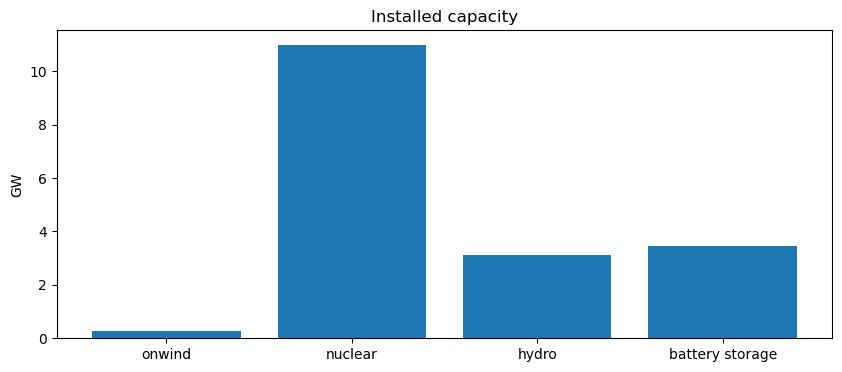

In [46]:
# Extract results
gen_cap = pd.concat([network.generators.p_nom_opt, network.storage_units.p_nom_opt], axis=0)
gen_cap = gen_cap[gen_cap != 0].div(1E3)  # GW
gen_prod = network.generators_t.p
total_gen_prod = pd.concat([gen_prod, network.storage_units_t.p_dispatch, -network.storage_units_t.p_store], axis=1)

# Plotting the resulting capacity
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.bar(gen_cap.index, gen_cap.values)
ax.set_xticks(ticks = gen_cap.index, labels = gen_cap.index)
ax.set_title("Installed capacity")
ax.set_ylabel("GW")
plt.show()

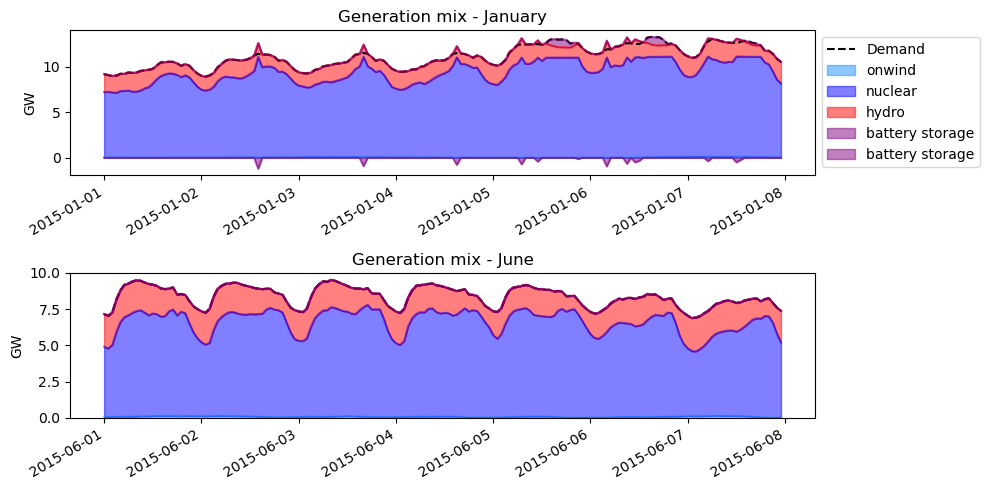

In [47]:
# Plot a week of generation
start_date_jan = "2015-01-01"
end_date_jan = "2015-01-7"
start_date_jun = "2015-06-01"
end_date_jun = "2015-06-7"

demand_jan = demand.loc[start_date_jan:end_date_jan].div(1e3) # Convert to GW
generator_jan = total_gen_prod.loc[start_date_jan:end_date_jan,  (total_gen_prod != 0).any(axis=0)].div(1e3)

demand_jun = demand.loc[start_date_jun:end_date_jun, ].div(1e3)
generator_jun = total_gen_prod.loc[start_date_jun:end_date_jun, (total_gen_prod != 0).any(axis=0)].div(1e3)


fig, ax = plt.subplots(2, 1, figsize=(10,5))
ax[0].plot(demand_jan.index, demand_jan.values, label="Demand", color="black", linestyle="--")
generator_jan.plot.area(ax=ax[0], alpha=0.5, stacked=True, color=generator_jan.columns.map(network.carriers.color), legend=True)
ax[0].set_title("Generation mix - January")
ax[0].set_ylabel("GW")
ax[0].set_xlabel("")
ax[0].legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)

ax[1].plot(demand_jun.index, demand_jun.values, label="Demand", color="black", linestyle="--")
generator_jun.plot.area(ax=ax[1], alpha=0.5, stacked=True, color=generator_jun.columns.map(network.carriers.color), legend=False)
ax[1].set_title("Generation mix - June")
ax[1].set_ylabel("GW")
ax[1].set_xlabel("")

plt.subplots_adjust(hspace=0.5, bottom=0.1, right=0.95, top=0.9)
plt.tight_layout()
plt.show()

## E: Determine CO2 price for CO2 target

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 33.57it/s]
INFO:linopy.io: Writing time: 1.56s
INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-6i1oe8gb.lp
INFO:gurobipy:Reading time = 0.44 seconds
INFO:gurobipy:obj: 192730 rows, 87608 columns, 398940 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87608 primals, 192730 duals
Objective: 6.66e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-

CO2 price: 167 €/tCO2


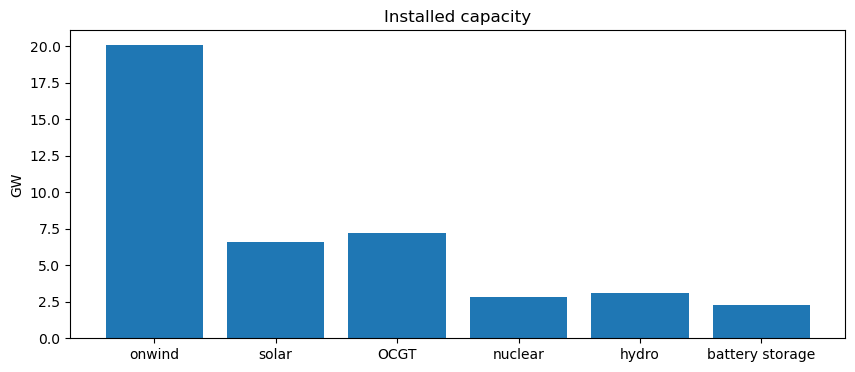

In [48]:
# Set CO2 limit and optimize again
network.global_constraints.loc["CO2Limit", "constant"] = 6.23 * 1E6 # MtCO2/a

# Optimize model
with suppress_stdout():
    network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

# Extract CO2 price
co2_price = -network.global_constraints.mu['CO2Limit']

print(f"CO2 price: {round(co2_price)} €/tCO2")

# Extract results
gen_cap = pd.concat([network.generators.p_nom_opt, network.storage_units.p_nom_opt], axis=0)
gen_cap = gen_cap[gen_cap != 0].div(1E3)  # GW
gen_prod = network.generators_t.p
total_gen_prod = pd.concat([gen_prod, network.storage_units_t.p_dispatch, -network.storage_units_t.p_store], axis=1)

# Plotting the resulting capacity
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.bar(gen_cap.index, gen_cap.values)
ax.set_xticks(ticks = gen_cap.index, labels = gen_cap.index)
ax.set_title("Installed capacity")
ax.set_ylabel("GW")
plt.show()

## F: Connect with neighbours

In [49]:
### Connect with estonia and sweden ###
network = pypsa.Network()
network.set_snapshots(snapshots.values)
countries = ["FIN", "EST", "SWE"]
coordinates = {
    "FIN": (64, 26),
    "EST": (59, 26),
    "SWE": (62, 15),
}

# Add a CO2 limit constraint
network.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=10E6, #MtCO2
    type="primary_energy",
)

# Add carriers to the network with CO2 emissions and colors
for i, carrier in enumerate(carriers):
    network.add("Carrier", carrier, co2_emissions=costs.at[carrier, "CO2 intensity"], color=colors[i])

# Add the new countries to the network
for country in countries:
    network.add("Bus", f"{country}_el", y = coordinates[country][0], x = coordinates[country][1], carrier = "AC")
    # network.add("Bus", f"{country}_storage", carrier="battery storage", y = coordinates[country][0], x = coordinates[country][1])


    CF = pd.DataFrame(1, index=snapshots, columns=carriers)
    CF = CF.assign(onwind=onshore_all.loc[onshore_all.index.year == year, country].values,
                   solar=solar_all.loc[solar_all.index.year == year, country].values, 
                   hydro=hydro_2015.loc[hydro_2015.index.year == year].values )
    

    for carrier in carriers:
        if carrier != "battery storage":
            network.add("Generator", f"{carrier}_{country}", bus=f"{country}_el", p_nom_extendable=True,
                        p_max_pu=CF[carrier].values,
                        marginal_cost=costs.at[carrier, "marginal_cost"],
                        efficiency=costs.at[carrier, "efficiency"],
                        capital_cost=costs.at[carrier, "capital_cost"],
                        carrier=carrier
            )

    # Add electricity load
    network.add("Load", f"el_load_{country}", bus=f"{country}_el", p_set=demand_all.loc[demand.index.year == year, country].values)

    network.add(
    "StorageUnit",
    f"{country}_battery storage",
    bus=f"{country}_el",
    carrier="battery storage",
    max_hours=2,
    capital_cost=costs.at["battery inverter", "capital_cost"]
    + 2 * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
    overwrite=True,
    )

# Limit hydro capacity for each country corresponding to the installed capacity in 2015
network.generators.loc["hydro_EST", "p_nom_max"] = 0
network.generators.loc["hydro_FIN", "p_nom_max"] = 3100 # MW
network.generators.loc["hydro_SWE", "p_nom_max"] = 16_301 # MW

# Add interconnectors between countries
network.add("Link", "FIN-EST", bus0 = "FIN_el", bus1 = "EST_el", p_nom = 1e3, efficiency=0.95, p_max_pu=1, p_min_pu=-1, carrier = "AC")
network.add("Link", "FIN-SWE", bus0 = "FIN_el", bus1 = "SWE_el", p_nom = 2.4e3, efficiency=0.95, p_max_pu=1, p_min_pu=-1, carrier = "AC")

In [50]:
with suppress_stdout():
    network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 11.86it/s]
INFO:linopy.io: Writing time: 5.02s
INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-to05ks5d.lp
INFO:gurobipy:Reading time = 1.45 seconds
INFO:gurobipy:obj: 613228 rows, 280344 columns, 1266563 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 280344 primals, 613228 duals
Objective: 1.49e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, Stor

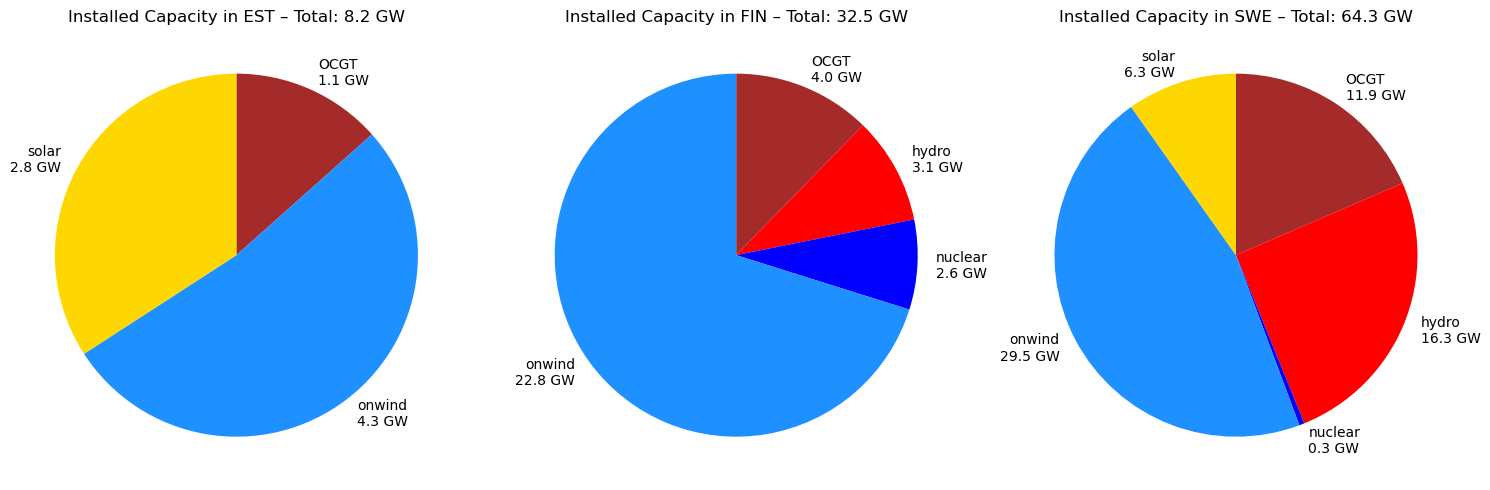

In [51]:
# Group installed capacities by bus and carrier
capacity_data = network.generators.p_nom_opt.groupby(
    [network.generators.bus, network.generators.carrier]
).sum().div(1e3).round(1)  # in GW

# Extract unique country codes
countries = sorted({bus.split("_")[0] for bus in capacity_data.index.get_level_values(0)})

# Plot pie charts
fig, axs = plt.subplots(1, len(countries), figsize=(5 * len(countries), 5))

for i, country in enumerate(countries):
    # Filter data for current country
    country_data = capacity_data.loc[capacity_data.index.get_level_values(0) == f"{country}_el"]
    
    # Filter out zero-capacity entries
    filtered = country_data[country_data > 0]
    
    labels = filtered.index.get_level_values(1)  # technology names
    values = filtered.values
    total_gw = values.sum().round(1)

    colors_used = [network.carriers.at[tech, "color"] if tech in network.carriers.index else "gray" for tech in labels]

    # Create labels showing tech and GW
    label_with_gw = [f"{label}\n{value:.1f} GW" for label, value in zip(labels, values)]

    axs[i].pie(
        values,
        labels=label_with_gw,
        colors=colors_used,
        startangle=90,
        counterclock=False
    )
    axs[i].axis("equal")
    axs[i].set_title(f"Installed Capacity in {country} – Total: {total_gw:.1f} GW")

plt.tight_layout()
plt.show()

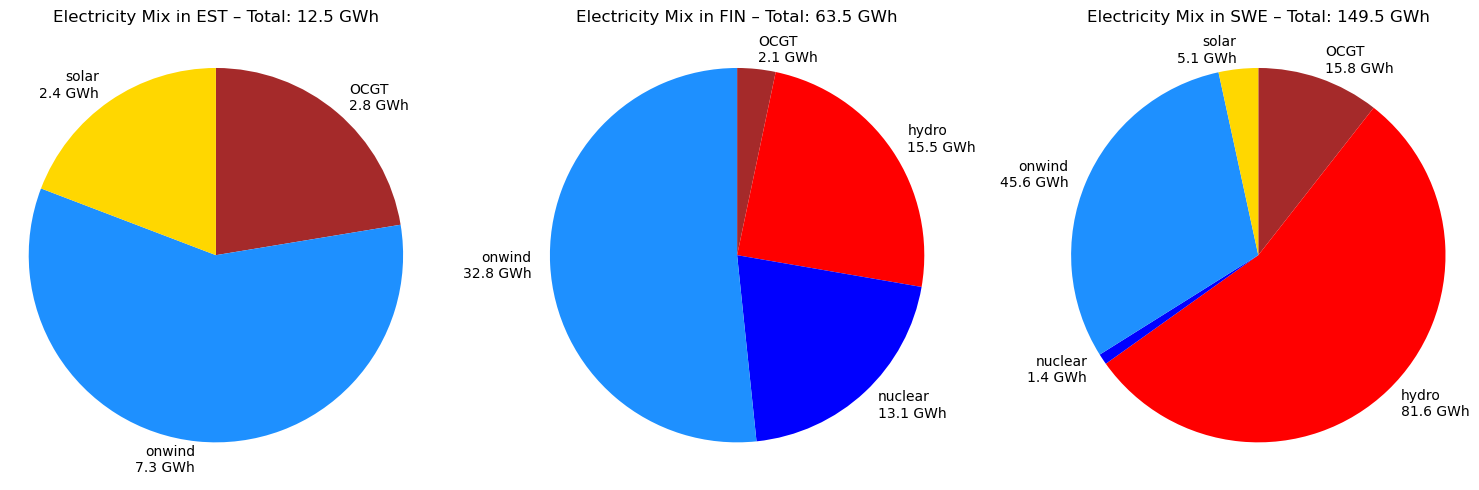

In [52]:
# Group generation by bus and carrier
generation_data = network.generators_t.p.sum(axis=0).groupby(
    [network.generators.bus, network.generators.carrier]
).sum().div(1e6).round(1)  # in GWh

# Extract country names
countries = sorted({bus.split("_")[0] for bus in generation_data.index.get_level_values(0)})

# Plot pie charts
fig, axs = plt.subplots(1, len(countries), figsize=(5 * len(countries), 5))

for i, country in enumerate(countries):
    # Filter generation data for this country
    country_data = generation_data.loc[generation_data.index.get_level_values(0) == f"{country}_el"]
    
    # Filter out zero-generation entries
    filtered = country_data[country_data > 0]
    
    labels = filtered.index.get_level_values(1)  # technology names
    values = filtered.values
    total_gwh = values.sum().round(1)

    colors_used = [network.carriers.at[tech, "color"] if tech in network.carriers.index else "gray" for tech in labels]
    
    # Combine label with GWh only
    label_with_gwh = [f"{label}\n{value:.1f} GWh" for label, value in zip(labels, values)]
    
    axs[i].pie(
        values,
        labels=label_with_gwh,
        colors=colors_used,
        startangle=90,
        counterclock=False
    )
    axs[i].axis("equal")
    axs[i].set_title(f"Electricity Mix in {country} – Total: {total_gwh:.1f} GWh")

plt.tight_layout()
plt.show()

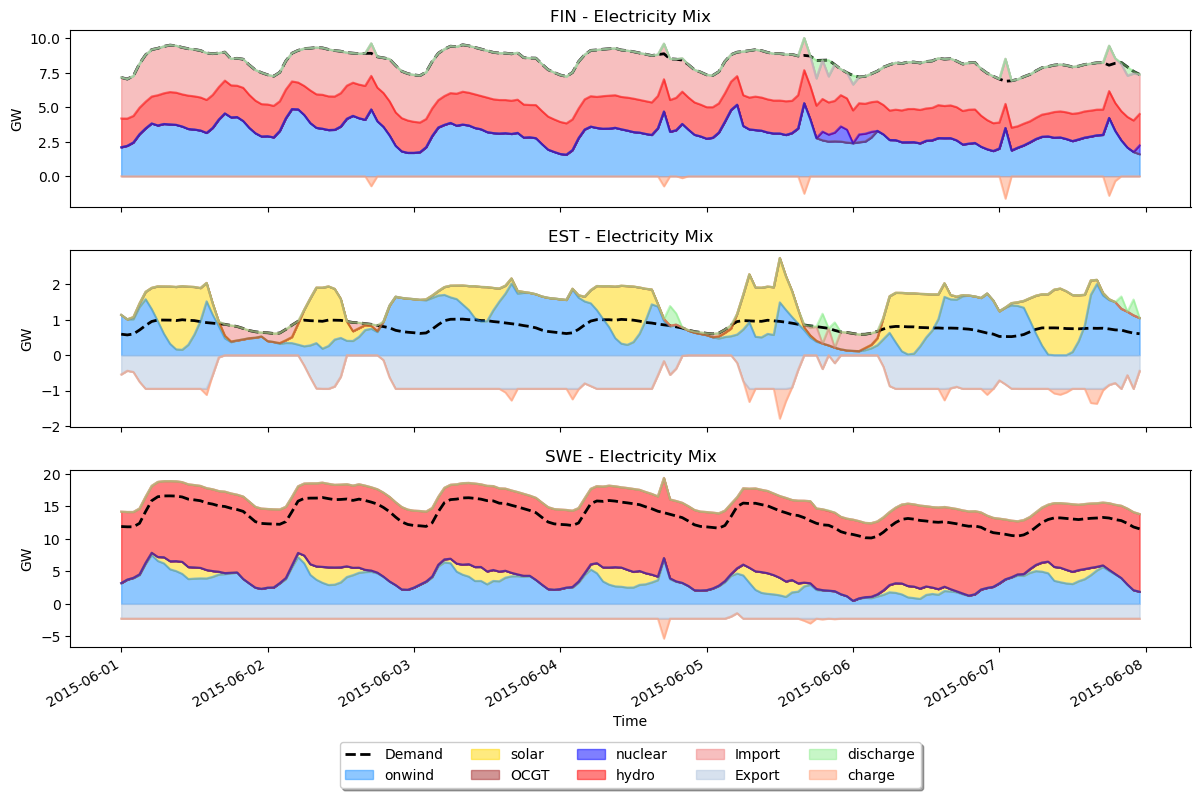

In [53]:
swe_exchange = network.links_t.p1["FIN-SWE"]
est_exchange = network.links_t.p1["FIN-EST"]
fin_exchange = network.links_t.p0.sum(axis=1)

# Split the data into positive and negative columns for import and export for each country
swe_import = swe_exchange[swe_exchange < 0].copy()
swe_export = swe_exchange[swe_exchange > 0].copy()
est_import = est_exchange[est_exchange < 0].copy()
est_export = est_exchange[est_exchange > 0].copy()
fin_import = fin_exchange[fin_exchange < 0].copy()
fin_export = fin_exchange[fin_exchange > 0].copy()

# Create combined DataFrame for plotting
exchange_data = pd.DataFrame({
    "SWE_Import": swe_import,
    "SWE_Export": swe_export,
    "EST_Import": est_import,
    "EST_Export": est_export,
    "FIN_Import": fin_import,
    "FIN_Export": fin_export
})
exchange_data = -exchange_data.div(1e3)

# Define the week
start_date = "2015-06-01"
end_date = "2015-06-07"
countries = ["FIN", "EST", "SWE"]
generators_clean = network.generators_t.p.loc[start_date:end_date, (network.generators_t.p != 0).any(axis=0)].div(1e3)  # GW


# Prepare the figure
fig, axs = plt.subplots(len(countries), 1, figsize=(12, 8), sharex=True)

for i, country in enumerate(countries):
    # Get generation for the country
    gen_cols = [col for col in generators_clean.columns if col.endswith(f"_{country}")]
    generation = network.generators_t.p.loc[start_date:end_date, gen_cols].div(1e3)  # GW
    generation.columns = [col.split("_")[0] for col in gen_cols]  # simplify labels
    # generation = generation.loc[:, (network.generators_t.p != 0).any(axis=0)]  # remove zero columns

    
    # Determine battery operation
    battery = pd.DataFrame({"discharge" : network.storage_units_t.p_dispatch[f"{country}_battery storage"],
                            "charge" :  -network.storage_units_t.p_store[f"{country}_battery storage"]})
    battery[abs(battery) < 0.01] = 0 # Set small values to zero
    battery = battery.loc[start_date:end_date].div(1e3)  # Convert to GW

    # Plot demand line

    demand = network.loads_t.p_set.loc[start_date:end_date, f"el_load_{country}"].div(1e3)  # GW
    axs[i].plot(demand.index, demand.values, color="black", label="Demand", linewidth=2, linestyle="--")

    # Get net imports: sum of incoming/outgoing flows
    exchange = exchange_data.loc[start_date:end_date, [f"{country}_Import", f"{country}_Export"]]
    exchange.rename(columns={f"{country}_Import": "Import", f"{country}_Export": "Export"}, inplace=True)
    
    generation = pd.concat([generation, exchange, battery], axis=1)

    

    # Plot generation stack
    color=[network.carriers.color.get(carrier) for carrier in generation.columns]
    color = [c for c in color if c != None]  # Remove color for non-existing carriers
    color.extend(["lightcoral", "lightsteelblue", "lightgreen", "lightsalmon"])
    generation.plot.area(ax=axs[i], alpha=0.5, stacked=True,
                         color=color,
                         legend=False)

    

    # Labels and title
    axs[i].set_title(f"{country} - Electricity Mix")
    axs[i].set_ylabel("GW")
    # axs[i].legend(loc="upper left", fontsize=8)

# axs[-1].legend(loc="upper left", fontsize=8)
axs[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5),
          fancybox=True, shadow=True, ncol=5)
axs[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()

In [54]:
#Get CO2 price
F_CO2_price = -network.global_constraints.mu['CO2Limit']
print(F_CO2_price)

274.89820123183017


In [55]:
# import cartopy.crs as ccrs

# fig, ax = plt.subplots(figsize=(10,4))
# network.plot(bus_sizes = 1/5, margin = 1, projection=ccrs.EqualEarth(),
#     color_geomap=True,
#     line_colors=network.lines_t.p0.mean().abs(),)
# plt.show()

In [56]:
# network.generators.p_nom_opt.plot.bar()

In [57]:
# gen = network.generators.assign(g=network.generators_t.p.sum()).groupby(["bus", "carrier"]).g.sum()
# gen_unstacked = gen.unstack()
# gen_unstacked.div(1E3).plot.bar()
# plt.ylabel("GWh")
# plt.show()

## G: Add sector coupling

In [58]:
# Import temperature data
temp_est = pd.read_excel("Estland_temp.xlsx")
temp_est.index = pd.to_datetime(temp_est['Päev'].astype(str) + '-' + 
                                temp_est['Kuu'].astype(str) + '-' + 
                                temp_est['Aasta'].astype(str) + " " +
                                temp_est["Kell (UTC)"].astype(str),
                                format='%d-%m-%Y %H:%M:%S')
temp_est = temp_est["Õhutemperatuur °C"]

temp_swe = pd.read_csv("Sverige_temp.csv")
temp_swe.index = pd.to_datetime(temp_swe['Day'].astype(str) + '-' + 
                                temp_swe['Month'].astype(str) + '-' + 
                                temp_swe['Year'].astype(str) + " " +
                                temp_swe["Time [UTC]"].astype(str),
                                format='%d-%m-%Y %H:%M')
temp_swe = temp_swe["Average temperature [°C]"]

temp_fin = pd.read_csv("Finland_temp.csv", sep=";")
temp_fin.index = pd.to_datetime(temp_fin['Datum'].astype(str) + " " +
                                temp_fin["Tid (UTC)"].astype(str),
                                format='%d-%m-%Y %H:%M:%S') 
temp_fin = temp_fin["Lufttemperatur"]

temperature_df = pd.concat(
    [temp_est.rename("EST"), temp_fin.rename("FIN"), temp_swe.rename("SWE")], 
    axis=1
)

temperature_df = temperature_df.loc[(temperature_df.index.year >= 2012) & (temperature_df.index.year < 2018)]

In [59]:
T_sink = 55 # temperature of the heat sink

def cop(t_source, t_sink=55):
    delta_t = t_sink - t_source
    cop = (6.81 - 0.121 * delta_t + 0.00063 * delta_t**2)
    cop = cop.fillna(method="ffill")
    return cop.values

network.add("Bus", "gas", carrier="OCGT") # Dummy gas bus
network.add("Store", "gas", e_initial=1E9, e_nom=1E9, bus="gas", carrier = "OCGT") 
network.add("Carrier","heat")


for country in countries:
    network.add("Bus", f"{country}_heat", y = coordinates[country][0], x = coordinates[country][1], carrier="heat")
    network.add("Load", f"heat_load_{country}", bus=f"{country}_heat", p_set=heat_all.loc[:,country].values, carrier = "heat")
    
    network.add(
        "Link",
        f"gas boiler_{country}",
        bus0="gas",
        bus1=f"{country}_heat",
        capital_cost=costs.at["gas boiler steam", "capital_cost"],  # €/MW/a
        marginal_cost=costs.at["gas boiler steam", "marginal_cost"],  # €/MWh
        p_nom_extendable=True,
        efficiency=costs.at["gas boiler steam", "efficiency"],
        carrier = "OCGT"
    )

    # Add heat pump
    temp = temperature_df.loc[temperature_df.index.year == year,f"{country}"] 

    network.add(
        "Link",
        f"heat pump_{country}",
        bus0=f"{country}_el",
        bus1=f"{country}_heat",
        efficiency=cop(temp),
        p_nom_extendable=True,
        capital_cost=costs.at["central air-sourced heat pump", "capital_cost"],  # €/MWe/a
        marginal_cost=costs.at["central air-sourced heat pump", "marginal_cost"],  # €/MWh
        carrier = "heat"
    )


    network.add("Link", f"central gas CHP_{country}",
                bus0="gas",
                bus1=f"{country}_el",
                bus2=f"{country}_heat",
                efficiency=costs.loc["central gas CHP", "efficiency"],
                efficiency2=costs.loc["central gas CHP", "efficiency"],
                p_nom_extendable=True,
                marginal_cost=costs.loc["central gas CHP", "marginal_cost"], # €/MWh
                capital_cost=costs.at["central gas CHP", "capital_cost"],  # €/MWe/a
                carrier = "OCGT"
    )

    # Add heat storage
    network.add("StorageUnit", f"{country}_PTES",
                bus=f"{country}_heat",
                carrier="heat",
                capital_cost = 350, # €/MWh
                efficiency_store=0.8,
                standing_loss = 0.0002,
                efficiency_dispatch=1,
                p_nom_extendable=True,
                cyclic_state_of_charge=True,
    )

In [60]:
with suppress_stdout():
    network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

Index(['FIN-EST', 'FIN-SWE', 'gas boiler_FIN', 'heat pump_FIN'], dtype='object', name='Link')
Index(['FIN-EST', 'FIN-SWE', 'gas boiler_FIN', 'heat pump_FIN'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 12.44it/s]
INFO:linopy.io: Writing time: 6.91s
INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-jzmpd7ia.lp
INFO:gurobipy:Reading time = 1.97 seconds
INFO:gurobipy:obj: 1016200 rows, 455556 columns, 2133815 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 455556 primals, 1016200 duals
Objective: 2.16e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize

<Axes: ylabel='Link'>

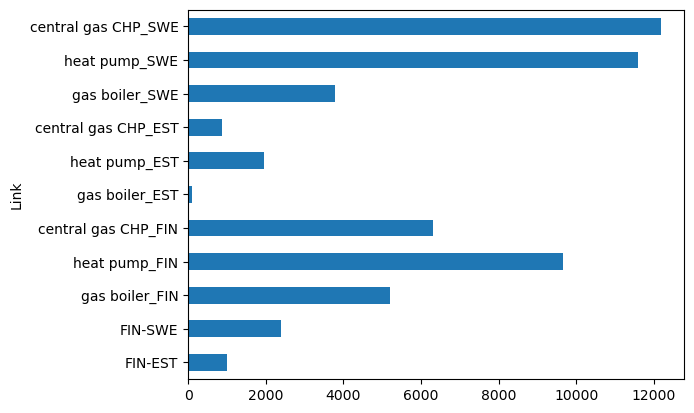

In [61]:
network.links.p_nom_opt.plot.barh()

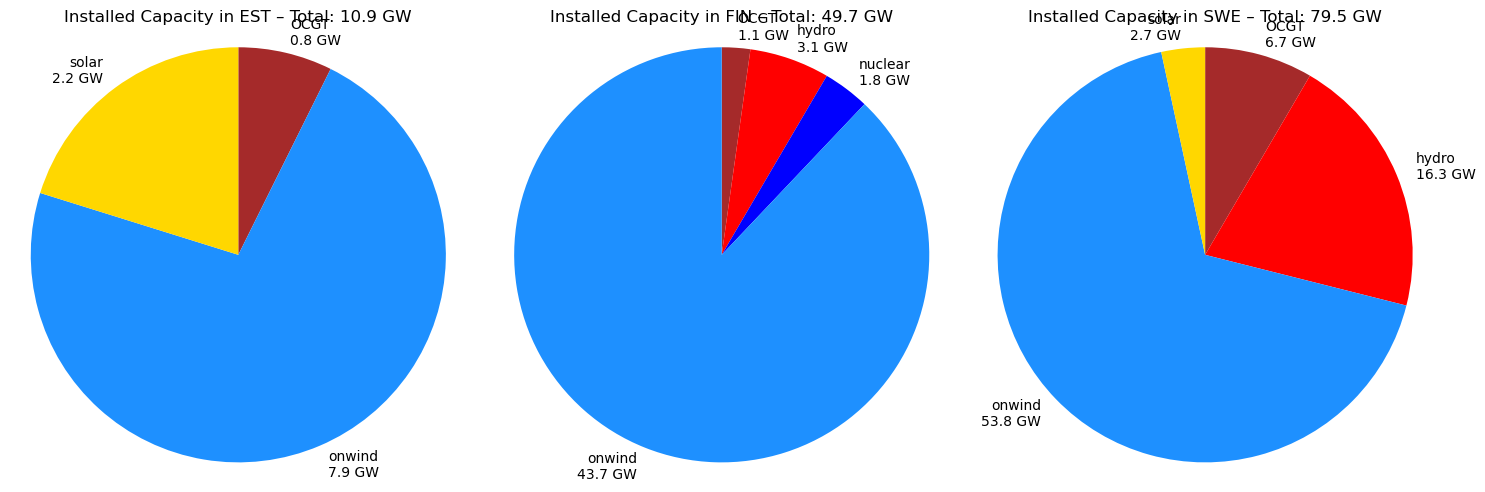

In [62]:
# Group installed capacities by bus and carrier
capacity_data = network.generators.p_nom_opt.groupby(
    [network.generators.bus, network.generators.carrier]
).sum().div(1e3).round(1)  # in GW

# Extract unique country codes
countries = sorted({bus.split("_")[0] for bus in capacity_data.index.get_level_values(0)})

# Plot pie charts
fig, axs = plt.subplots(1, len(countries), figsize=(5 * len(countries), 5))

for i, country in enumerate(countries):
    # Filter data for current country
    country_data = capacity_data.loc[capacity_data.index.get_level_values(0) == f"{country}_el"]
    
    # Filter out zero-capacity entries
    filtered = country_data[country_data > 0]
    
    labels = filtered.index.get_level_values(1)  # technology names
    values = filtered.values
    total_gw = values.sum().round(1)

    colors_used = [network.carriers.at[tech, "color"] if tech in network.carriers.index else "gray" for tech in labels]

    # Create labels showing tech and GW
    label_with_gw = [f"{label}\n{value:.1f} GW" for label, value in zip(labels, values)]

    axs[i].pie(
        values,
        labels=label_with_gw,
        colors=colors_used,
        startangle=90,
        counterclock=False
    )
    axs[i].axis("equal")
    axs[i].set_title(f"Installed Capacity in {country} – Total: {total_gw:.1f} GW")

plt.tight_layout()
plt.show()

In [63]:
#Get CO2 price
G_CO2_price = -network.global_constraints.mu['CO2Limit']

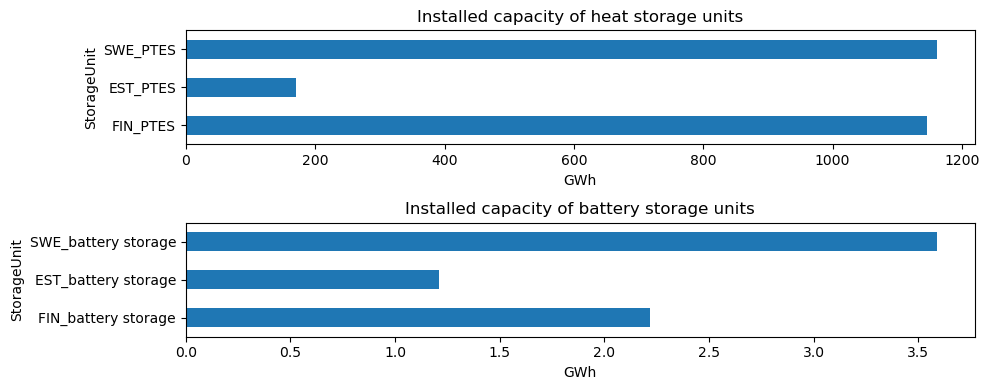

In [64]:
# Plot the installed capacity of the storage units
fig, ax = plt.subplots(2, 1, figsize=(10,4))
network.storage_units.loc[["FIN_PTES", "EST_PTES", "SWE_PTES"], "p_nom_opt"].div(1E3).plot.barh(ax=ax[0])
ax[0].set_title("Installed capacity of heat storage units")
ax[0].set_xlabel("GWh")

network.storage_units.loc[["FIN_battery storage", "EST_battery storage", "SWE_battery storage"], "p_nom_opt"].div(1E3).plot.barh(ax=ax[1])
ax[1].set_title("Installed capacity of battery storage units")
ax[1].set_xlabel("GWh")

plt.tight_layout()
plt.show()

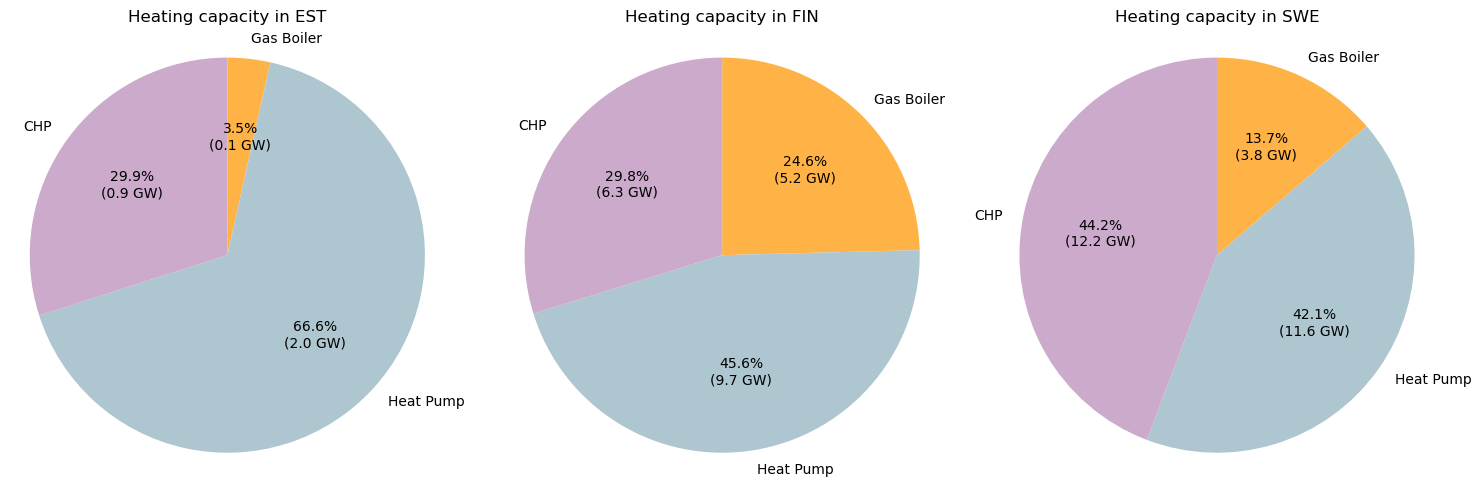

In [65]:


# Get link capacities
link_cap = network.links.p_nom_opt

# Set consistent label keys and colors
colors = {
    "Gas Boiler": "#FFB347",   # Pastel Orange
    "Heat Pump": "#AEC6CF",    # Pastel Blue
    "CHP": "#CBAACB",          # Pastel Purple
}

# Extract unique countries from link names
countries = sorted({link.split("_")[-1] for link in link_cap.index if "_" in link})

# Setup subplots: One pie chart per country
fig, axs = plt.subplots(1, len(countries), figsize=(5 * len(countries), 5))

# If only one country, axs won't be a list
if len(countries) == 1:
    axs = [axs]

for i, country in enumerate(countries):
    ax = axs[i]

    # Filter links for the current country
    country_links = link_cap[link_cap.index.str.contains(f"_{country}")]

    # Select relevant link types
    capacities = {
        "Gas Boiler": country_links[country_links.index.str.contains("gas boiler")].sum() /1e3,
        "Heat Pump": country_links[country_links.index.str.contains("heat pump")].sum() /1e3,
        "CHP": country_links[country_links.index.str.contains("central gas CHP")].sum() /1e3
    }

    # Remove zero values
    capacities = {k: v for k, v in capacities.items() if v > 0}

    # Pie chart
    ax.pie(
        capacities.values(),
        labels=capacities.keys(),
        colors=[colors[k] for k in capacities.keys()],
        startangle=90,
        counterclock=False,
        autopct=lambda pct: f"{pct:.1f}%\n({(pct / 100) * sum(capacities.values()):.1f} GW)"
    )
    ax.axis("equal")
    ax.set_title(f"Heating capacity in {country}")

plt.tight_layout()
plt.show()


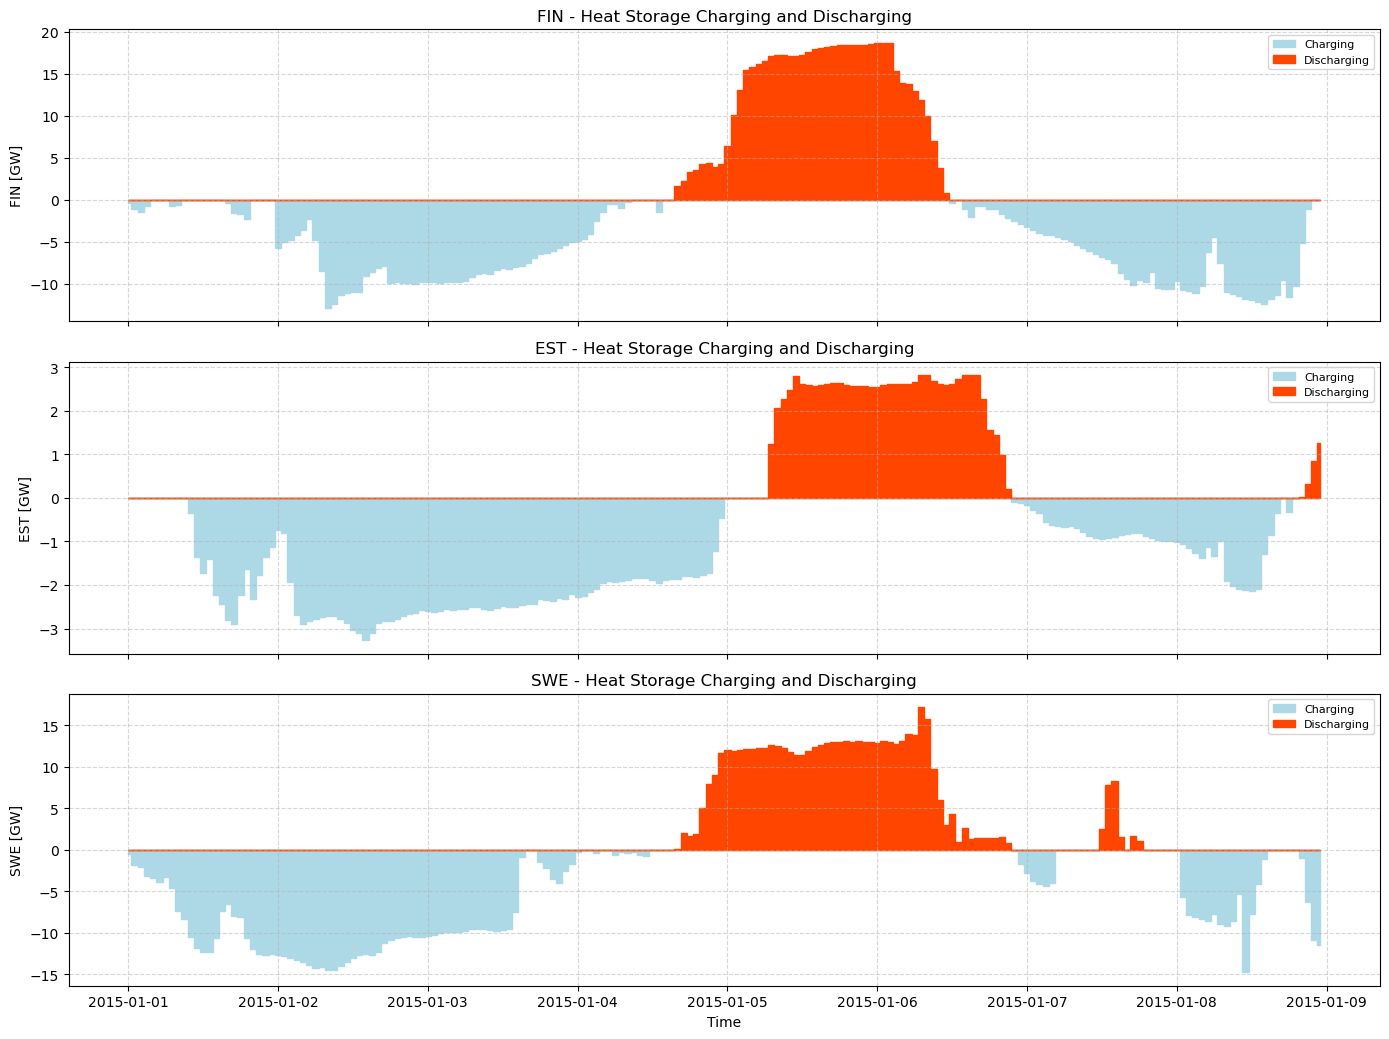

In [66]:

# Set time range and countries
start = "2015-01-01"
end = "2015-01-08"
countries = ["FIN", "EST", "SWE"]

# Prepare plot
fig, axs = plt.subplots(len(countries), 1, figsize=(14, 3.5 * len(countries)), sharex=True)

for i, country in enumerate(countries):
    ax = axs[i]

    # Charging (negative values mean charging)
    charge = network.storage_units_t.p_store.get(f"{country}_PTES", pd.Series(0)).loc[start:end].div(1e3)  # GW
    # Discharging
    discharge = network.storage_units_t.p_dispatch.get(f"{country}_PTES", pd.Series(0)).loc[start:end].div(1e3)  # GW

    # Plot stacked: charging as negative (fill down), discharging as positive (fill up)
    ax.fill_between(charge.index, 0, -charge, label="Charging", color="lightblue", step="mid")
    ax.fill_between(discharge.index, 0, discharge, label="Discharging", color="orangered", step="mid")

    ax.set_ylabel(f"{country} [GW]")
    ax.set_title(f"{country} - Heat Storage Charging and Discharging")
    ax.legend(loc="upper right", fontsize=8)
    ax.grid(True, linestyle="--", alpha=0.5)

axs[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()

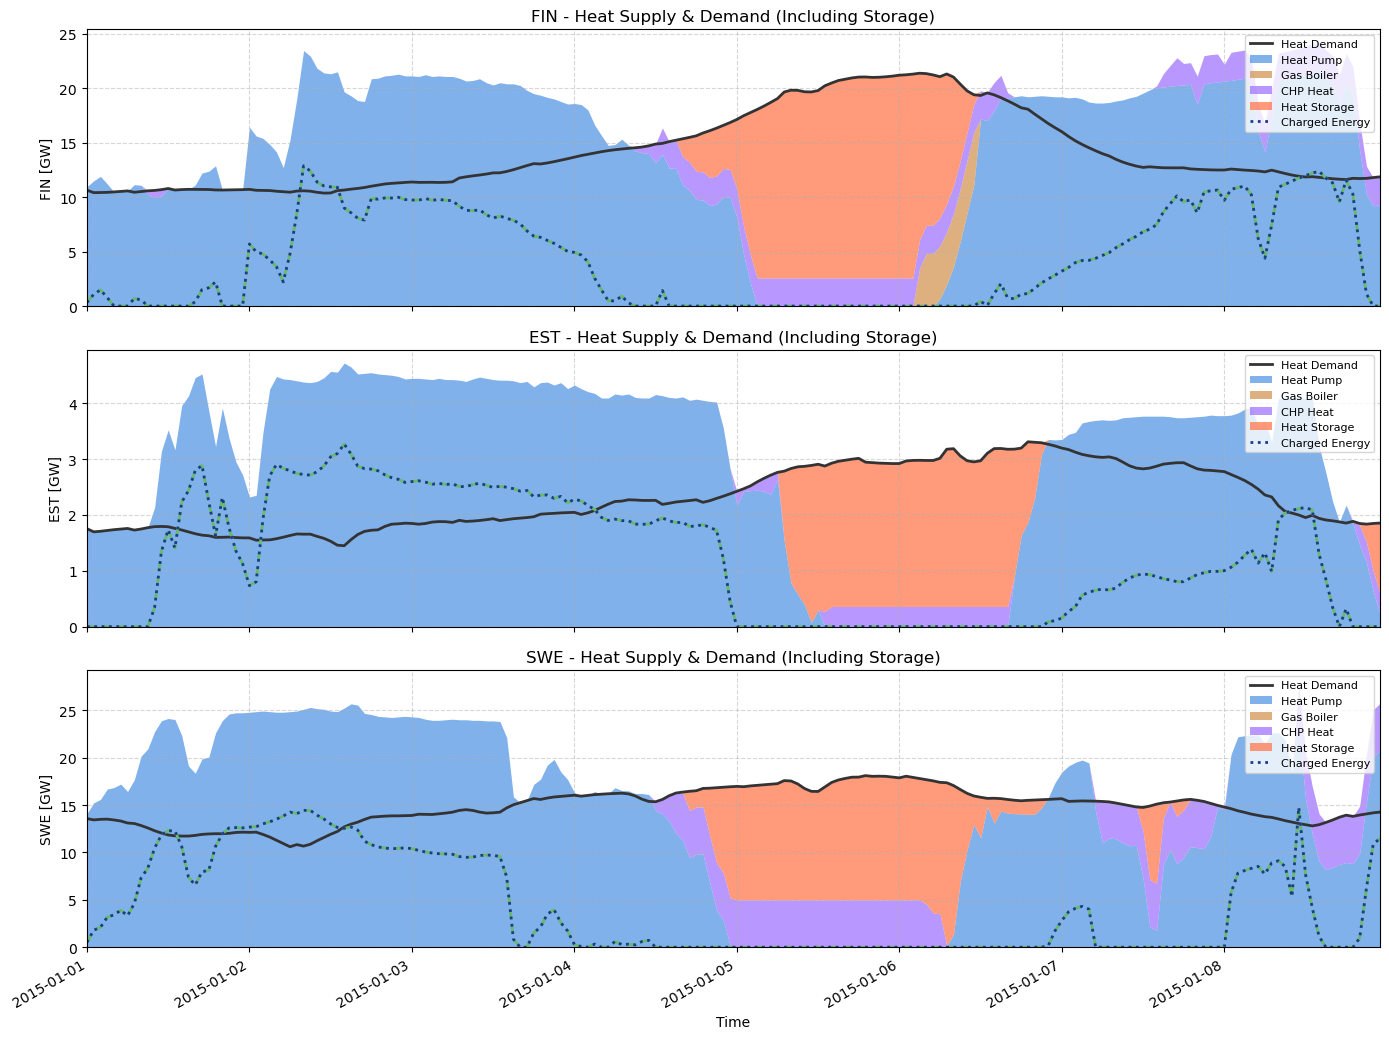

In [67]:
# Set time period and countries
start = "2015-01-01"
end = "2015-01-08"
countries = ["FIN", "EST", "SWE"]

colors = {
    "Heat Pump": "#4A90E2",  # Bright Blue
    "Gas Boiler": "#D18F4A",  # Warm Tan
    "CHP Heat": "#9B6DFF",  # Vibrant Lavender
    "Heat Storage": "#FF7043",  # Bright Orange
    "Heat Demand": "#333333",  # Dark Grey
    "Excess Energy": "#66BB6A",  # Fresh Green
    "Charged Energy": "#1E3A8A",  # Midnight Blue
}

# Setup subplots
fig, axs = plt.subplots(len(countries), 1, figsize=(14, 3.5 * len(countries)), sharex=True)

for i, country in enumerate(countries):
    ax = axs[i]
    heat_col = f"heat_load_{country}"

    # Extract heat demand
    heat_demand = network.loads_t.p_set[heat_col].loc[start:end].div(1e3)  # GW

    # Extract heat supply
    heat_pump = -network.links_t.p1.get(f"heat pump_{country}", pd.Series(0, index=heat_demand.index)).loc[start:end].div(1e3)
    gas_boiler = -network.links_t.p1.get(f"gas boiler_{country}", pd.Series(0, index=heat_demand.index)).loc[start:end].div(1e3)
    chp_heat = -network.links_t.p2.get(f"central gas CHP_{country}", pd.Series(0, index=heat_demand.index)).loc[start:end].div(1e3)
    
    # Add heat storage discharge (from state of charge)
    storage_unit = f"{country}_PTES"
    storage_discharge = network.storage_units_t.p_dispatch.get(storage_unit, pd.Series(0, index=heat_demand.index)).loc[start:end].div(1e3)

    # Combine into DataFrame
    df_heat = pd.DataFrame({
        "Heat Pump": heat_pump,
        "Gas Boiler": gas_boiler,
        "CHP Heat": chp_heat,
        "Heat Storage": storage_discharge
    })

    # Calculate Excess Energy
    total_supply = heat_pump + gas_boiler + chp_heat + storage_discharge  # Total energy produced
    excess_energy = total_supply - heat_demand  # Excess energy

    # Calculate Charged Energy (storage charging)
    charge_energy = network.storage_units_t.p_store.get(f"{country}_PTES", pd.Series(0, index=heat_demand.index)).loc[start:end].div(1e3)

    # Plot demand as line
    ax.plot(heat_demand.index, heat_demand.values, label="Heat Demand", color=colors["Heat Demand"], linewidth=2)

    # Plot stacked heat supply
    df_heat.plot.area(ax=ax, alpha=0.7, linewidth=0, color={k: colors[k] for k in df_heat.columns})

    # Plot Excess Energy as line, but without label
    ax.plot(excess_energy.index, excess_energy, color=colors["Excess Energy"], linewidth=2, linestyle="--")

    # Plot Charged Energy as line
    ax.plot(charge_energy.index, charge_energy, label="Charged Energy", color=colors["Charged Energy"], linewidth=2, linestyle=":")

    ax.set_ylabel(f"{country} [GW]")
    ax.set_title(f"{country} - Heat Supply & Demand (Including Storage)")

    # Set x-axis limits to match the start and end of the data
    ax.set_xlim(heat_demand.index[0], heat_demand.index[-1])

    ax.legend(loc="upper right", fontsize=8)
    ax.grid(True, linestyle="--", alpha=0.5)

# Shared x-axis for all subplots
axs[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()


## H: Explore new topic

In [68]:
# Impose a cap on onshore wind 
network.generators.loc["onwind_FIN", "p_nom_max"] = 21e3 # MW
network.generators.loc["onwind_EST", "p_nom_max"] = 2.3e3 # MW
network.generators.loc["onwind_SWE", "p_nom_max"] = 30e3 # MW

# Optimize
with suppress_stdout():
    network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

Index(['FIN-EST', 'FIN-SWE', 'gas boiler_FIN', 'heat pump_FIN'], dtype='object', name='Link')
Index(['FIN-EST', 'FIN-SWE', 'gas boiler_FIN', 'heat pump_FIN'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 12.61it/s]
INFO:linopy.io: Writing time: 6.84s
INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-32ifg0is.lp
INFO:gurobipy:Reading time = 1.96 seconds
INFO:gurobipy:obj: 1016203 rows, 455556 columns, 2133818 nonzeros
Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4



<Axes: ylabel='Generator'>

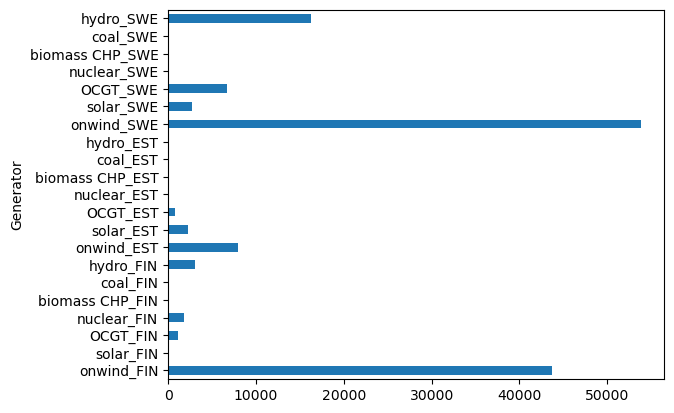

In [69]:
network.generators.p_nom_opt.plot.barh()

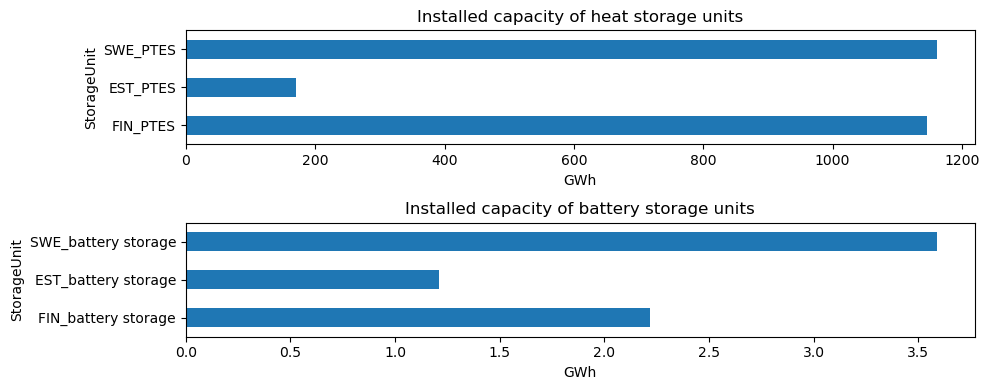

In [70]:
# Plot the installed capacity of the storage units
fig, ax = plt.subplots(2, 1, figsize=(10,4))
network.storage_units.loc[["FIN_PTES", "EST_PTES", "SWE_PTES"], "p_nom_opt"].div(1E3).plot.barh(ax=ax[0])
ax[0].set_title("Installed capacity of heat storage units")
ax[0].set_xlabel("GWh")

network.storage_units.loc[["FIN_battery storage", "EST_battery storage", "SWE_battery storage"], "p_nom_opt"].div(1E3).plot.barh(ax=ax[1])
ax[1].set_title("Installed capacity of battery storage units")
ax[1].set_xlabel("GWh")

plt.tight_layout()
plt.show()

<Axes: ylabel='Link'>

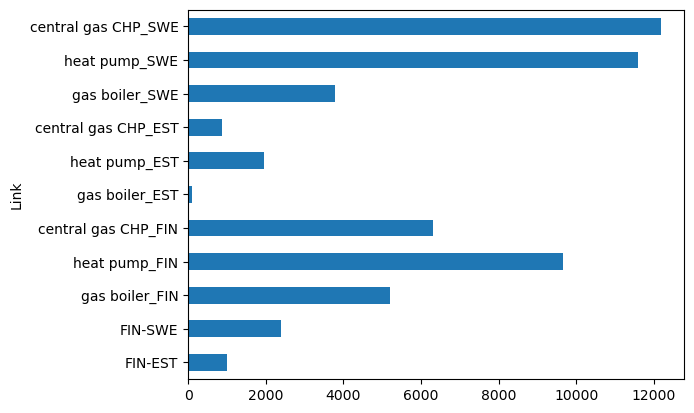

In [71]:
network.links.p_nom_opt.plot.barh()


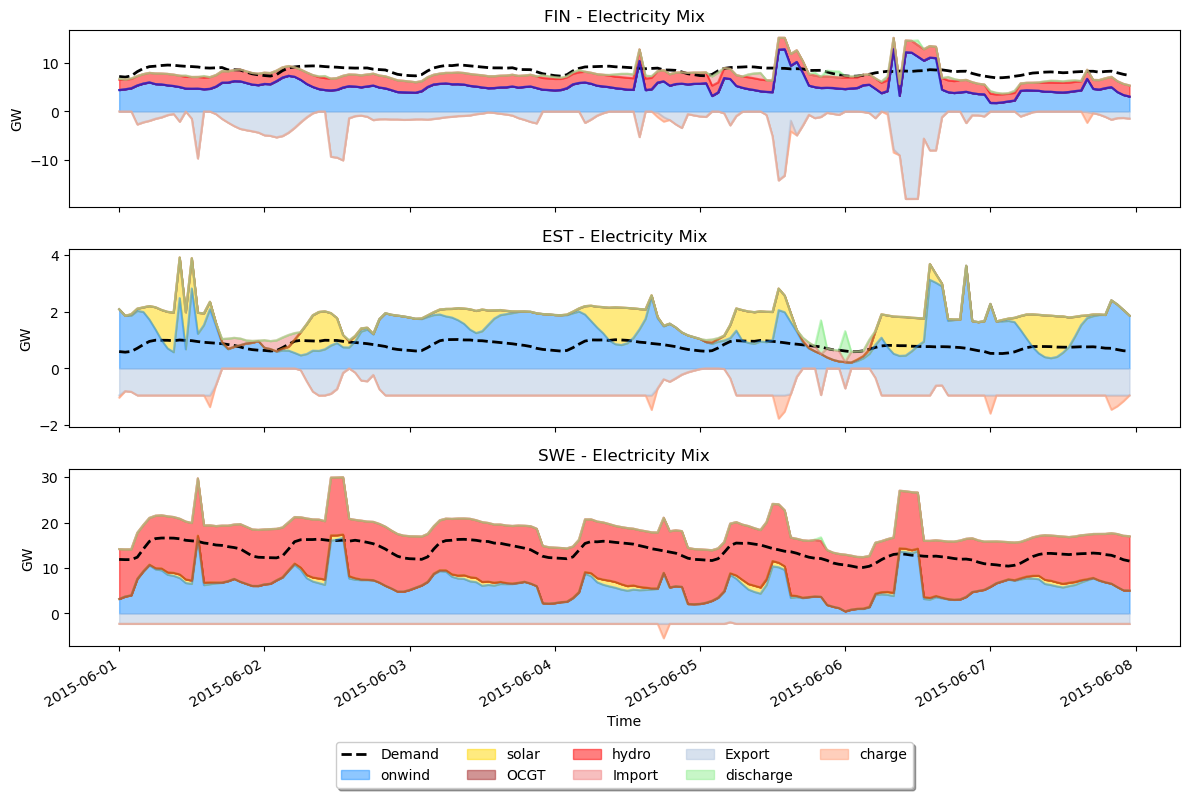

In [72]:
swe_exchange = network.links_t.p1["FIN-SWE"]
est_exchange = network.links_t.p1["FIN-EST"]
fin_exchange = network.links_t.p0.sum(axis=1)

# Split the data into positive and negative columns for import and export for each country
swe_import = swe_exchange[swe_exchange < 0].copy()
swe_export = swe_exchange[swe_exchange > 0].copy()
est_import = est_exchange[est_exchange < 0].copy()
est_export = est_exchange[est_exchange > 0].copy()
fin_import = fin_exchange[fin_exchange < 0].copy()
fin_export = fin_exchange[fin_exchange > 0].copy()

# Create combined DataFrame for plotting
exchange_data = pd.DataFrame({
    "SWE_Import": swe_import,
    "SWE_Export": swe_export,
    "EST_Import": est_import,
    "EST_Export": est_export,
    "FIN_Import": fin_import,
    "FIN_Export": fin_export
})
exchange_data = -exchange_data.div(1e3)

# Define the week
start_date = "2015-06-01"
end_date = "2015-06-07"
countries = ["FIN", "EST", "SWE"]
generators_clean = network.generators_t.p.loc[start_date:end_date, (network.generators_t.p != 0).any(axis=0)].div(1e3)  # GW


# Prepare the figure
fig, axs = plt.subplots(len(countries), 1, figsize=(12, 8), sharex=True)

for i, country in enumerate(countries):
    # Get generation for the country
    gen_cols = [col for col in generators_clean.columns if col.endswith(f"_{country}")]
    generation = network.generators_t.p.loc[start_date:end_date, gen_cols].div(1e3)  # GW
    generation.columns = [col.split("_")[0] for col in gen_cols]  # simplify labels
    # generation = generation.loc[:, (network.generators_t.p != 0).any(axis=0)]  # remove zero columns

    
    # Determine battery operation
    battery = pd.DataFrame({"discharge" : network.storage_units_t.p_dispatch[f"{country}_battery storage"],
                            "charge" :  -network.storage_units_t.p_store[f"{country}_battery storage"]})
    battery[abs(battery) < 0.01] = 0 # Set small values to zero
    battery = battery.loc[start_date:end_date].div(1e3)  # Convert to GW

    # Plot demand line

    demand = network.loads_t.p_set.loc[start_date:end_date, f"el_load_{country}"].div(1e3)  # GW
    axs[i].plot(demand.index, demand.values, color="black", label="Demand", linewidth=2, linestyle="--")

    # Get net imports: sum of incoming/outgoing flows
    exchange = exchange_data.loc[start_date:end_date, [f"{country}_Import", f"{country}_Export"]]
    exchange.rename(columns={f"{country}_Import": "Import", f"{country}_Export": "Export"}, inplace=True)
    
    generation = pd.concat([generation, exchange, battery], axis=1)

    

    # Plot generation stack
    color=[network.carriers.color.get(carrier) for carrier in generation.columns]
    color = [c for c in color if c != None]  # Remove color for non-existing carriers
    color.extend(["lightcoral", "lightsteelblue", "lightgreen", "lightsalmon"])
    generation.plot.area(ax=axs[i], alpha=0.5, stacked=True,
                         color=color,
                         legend=False)

    

    # Labels and title
    axs[i].set_title(f"{country} - Electricity Mix")
    axs[i].set_ylabel("GW")
    # axs[i].legend(loc="upper left", fontsize=8)

# axs[-1].legend(loc="upper left", fontsize=8)
axs[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5),
          fancybox=True, shadow=True, ncol=5)
axs[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()

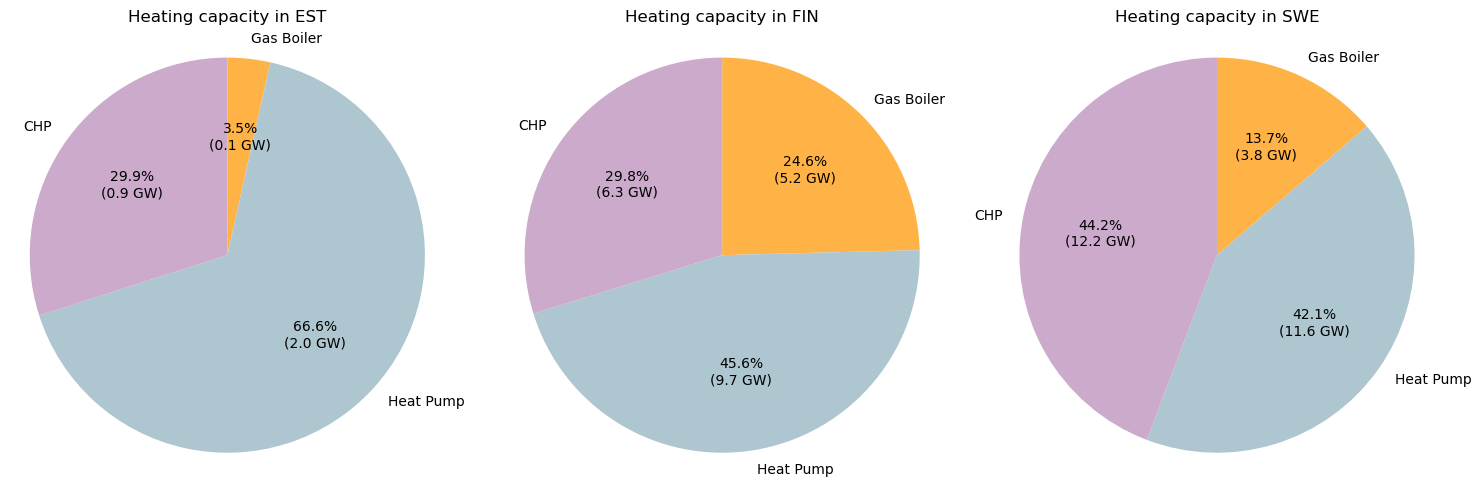

In [73]:
import matplotlib.pyplot as plt

# Get link capacities
link_cap = network.links.p_nom_opt

# Set consistent label keys and colors
colors = {
    "Gas Boiler": "#FFB347",   # Pastel Orange
    "Heat Pump": "#AEC6CF",    # Pastel Blue
    "CHP": "#CBAACB",          # Pastel Purple
}

# Extract unique countries from link names
countries = sorted({link.split("_")[-1] for link in link_cap.index if "_" in link})

# Setup subplots: One pie chart per country
fig, axs = plt.subplots(1, len(countries), figsize=(5 * len(countries), 5))

# If only one country, axs won't be a list
if len(countries) == 1:
    axs = [axs]

for i, country in enumerate(countries):
    ax = axs[i]

    # Filter links for the current country
    country_links = link_cap[link_cap.index.str.contains(f"_{country}")]

    # Select relevant link types
    capacities = {
        "Gas Boiler": country_links[country_links.index.str.contains("gas boiler")].sum() /1e3,
        "Heat Pump": country_links[country_links.index.str.contains("heat pump")].sum() /1e3,
        "CHP": country_links[country_links.index.str.contains("central gas CHP")].sum() /1e3
    }

    # Remove zero values
    capacities = {k: v for k, v in capacities.items() if v > 0}

    # Pie chart
    ax.pie(
        capacities.values(),
        labels=capacities.keys(),
        colors=[colors[k] for k in capacities.keys()],
        startangle=90,
        counterclock=False,
        autopct=lambda pct: f"{pct:.1f}%\n({(pct / 100) * sum(capacities.values()):.1f} GW)"
    )
    ax.axis("equal")
    ax.set_title(f"Heating capacity in {country}")

plt.tight_layout()
plt.show()


In [74]:
network.links.p_nom_opt



Link
FIN-EST                 1000.000000
FIN-SWE                 2400.000000
gas boiler_FIN          5205.379598
heat pump_FIN           9658.069009
central gas CHP_FIN     6303.972342
gas boiler_EST           103.018840
heat pump_EST           1961.112910
central gas CHP_EST      881.714637
gas boiler_SWE          3770.518333
heat pump_SWE          11585.564755
central gas CHP_SWE    12169.607574
Name: p_nom_opt, dtype: float64

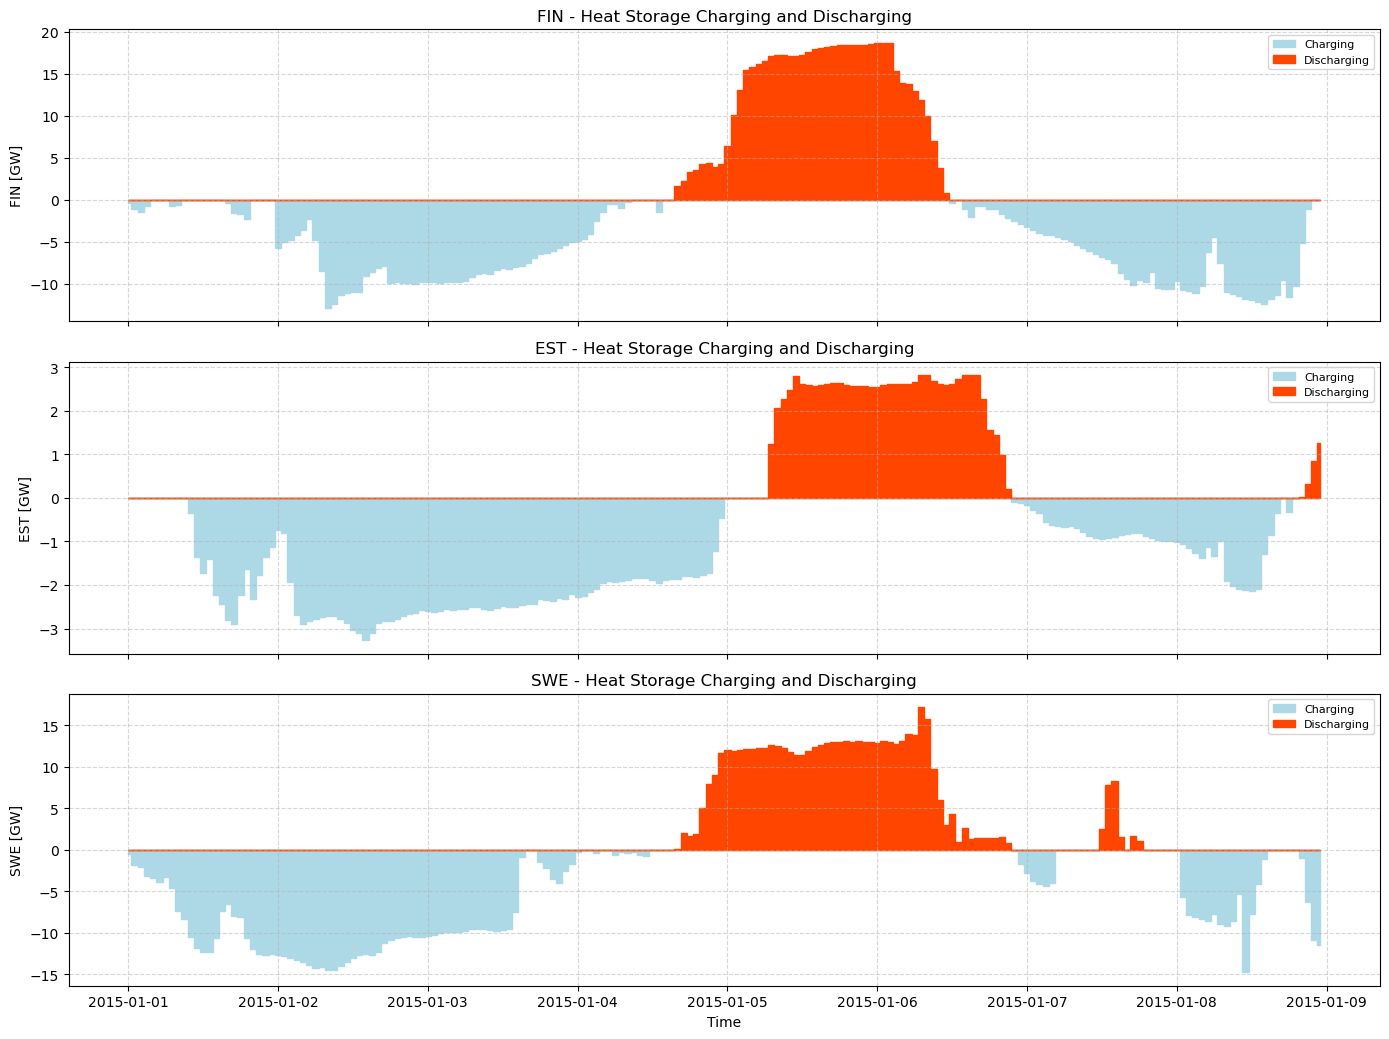

In [75]:
import matplotlib.pyplot as plt

# 💡 Set time range and countries
start = "2015-01-01"
end = "2015-01-08"
countries = ["FIN", "EST", "SWE"]

# 📐 Prepare plot
fig, axs = plt.subplots(len(countries), 1, figsize=(14, 3.5 * len(countries)), sharex=True)

for i, country in enumerate(countries):
    ax = axs[i]

    # 🔌 Charging (negative values mean charging)
    charge = network.storage_units_t.p_store.get(f"{country}_PTES", pd.Series(0)).loc[start:end].div(1e3)  # GW
    # 🔋 Discharging
    discharge = network.storage_units_t.p_dispatch.get(f"{country}_PTES", pd.Series(0)).loc[start:end].div(1e3)  # GW

    # Plot stacked: charging as negative (fill down), discharging as positive (fill up)
    ax.fill_between(charge.index, 0, -charge, label="Charging", color="lightblue", step="mid")
    ax.fill_between(discharge.index, 0, discharge, label="Discharging", color="orangered", step="mid")

    ax.set_ylabel(f"{country} [GW]")
    ax.set_title(f"{country} - Heat Storage Charging and Discharging")
    ax.legend(loc="upper right", fontsize=8)
    ax.grid(True, linestyle="--", alpha=0.5)

axs[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()

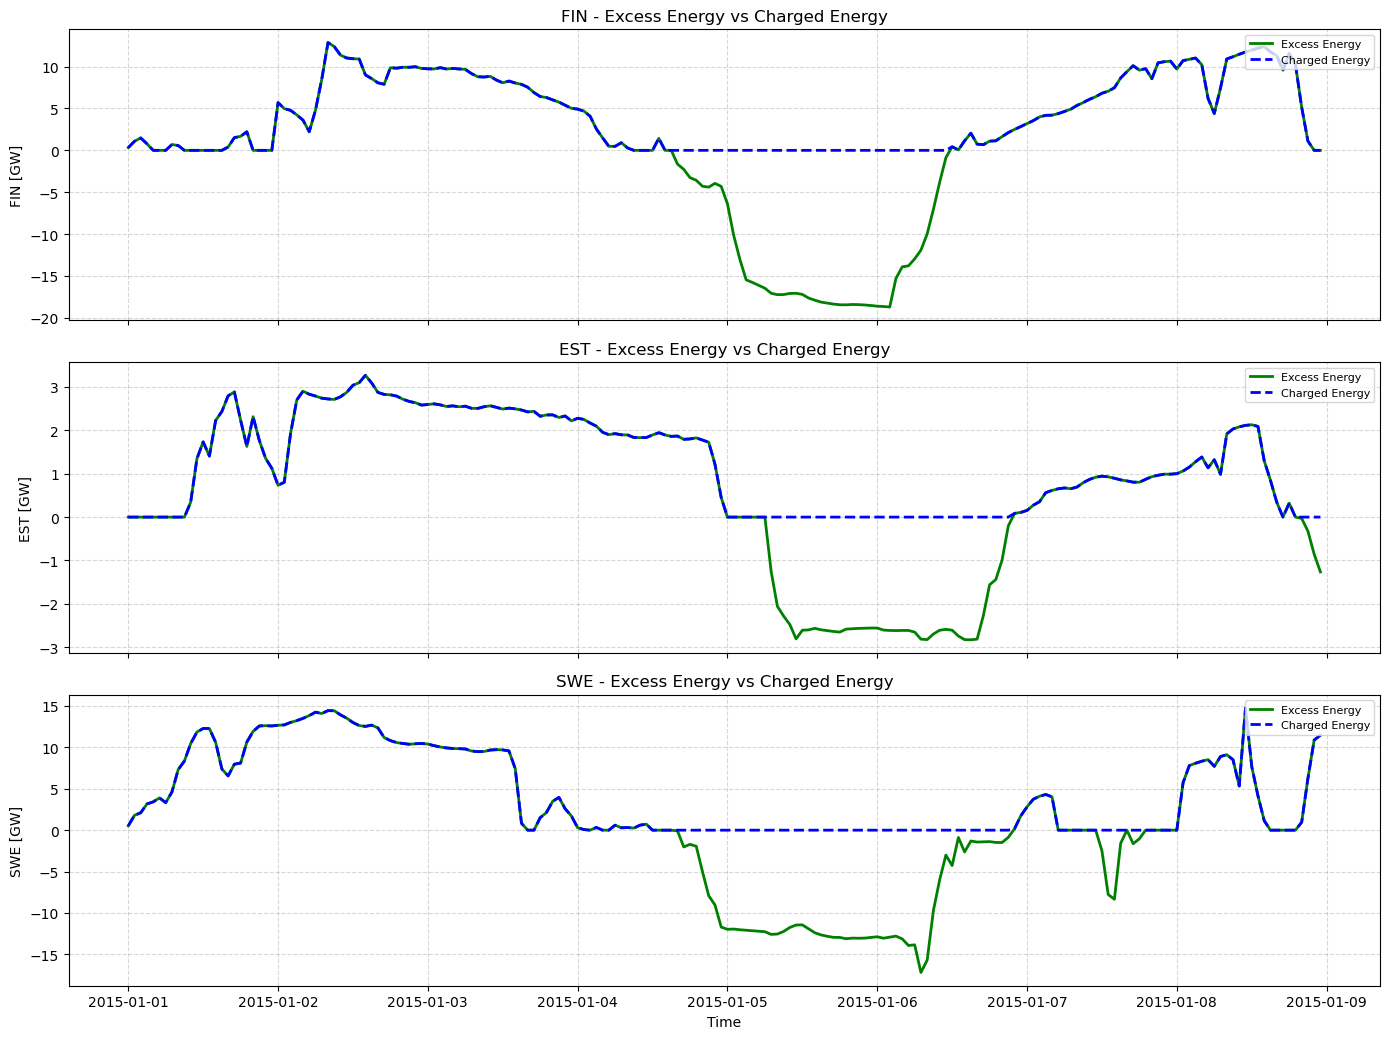

In [76]:
import matplotlib.pyplot as plt

# 🔧 Set time period and countries
start = "2015-01-01"
end = "2015-01-08"
countries = ["FIN", "EST", "SWE"]

# Custom colors for plotting
colors = {
    "Excess Energy": "green",
    "Charged Energy": "blue"
}

# Prepare plot for excess vs charged energy comparison
fig, axs = plt.subplots(len(countries), 1, figsize=(14, 3.5 * len(countries)), sharex=True)

for i, country in enumerate(countries):
    ax = axs[i]
    heat_col = f"heat_load_{country}"

    # Extract heat demand (in GW)
    heat_demand = network.loads_t.p_set[heat_col].loc[start:end].div(1e3)  # GW

    # Extract heat supply (total supply from various sources, in GW)
    heat_pump = -network.links_t.p1.get(f"heat pump_{country}", pd.Series(0, index=heat_demand.index)).loc[start:end].div(1e3)
    gas_boiler = -network.links_t.p1.get(f"gas boiler_{country}", pd.Series(0, index=heat_demand.index)).loc[start:end].div(1e3)
    chp_heat = -network.links_t.p2.get(f"central gas CHP_{country}", pd.Series(0, index=heat_demand.index)).loc[start:end].div(1e3)
    
    # Total heat supply (add up all heat sources)
    total_heat_supply = heat_pump + gas_boiler + chp_heat

    # Calculate excess energy (total supply - demand)
    excess_energy = total_heat_supply - heat_demand

    # Extract charging energy (from storage)
    storage_unit = f"{country}_PTES"
    charge_energy = network.storage_units_t.p_store.get(storage_unit, pd.Series(0, index=heat_demand.index)).loc[start:end].div(1e3)  # GW

    # Plot excess energy and charged energy
    ax.plot(excess_energy.index, excess_energy.values, label="Excess Energy", color=colors["Excess Energy"], linewidth=2)
    ax.plot(charge_energy.index, charge_energy.values, label="Charged Energy", color=colors["Charged Energy"], linewidth=2, linestyle="--")

    ax.set_ylabel(f"{country} [GW]")
    ax.set_title(f"{country} - Excess Energy vs Charged Energy")
    ax.legend(loc="upper right", fontsize=8)
    ax.grid(True, linestyle="--", alpha=0.5)

# Set xlabel for the last subplot
axs[-1].set_xlabel("Time")

plt.tight_layout()
plt.show()


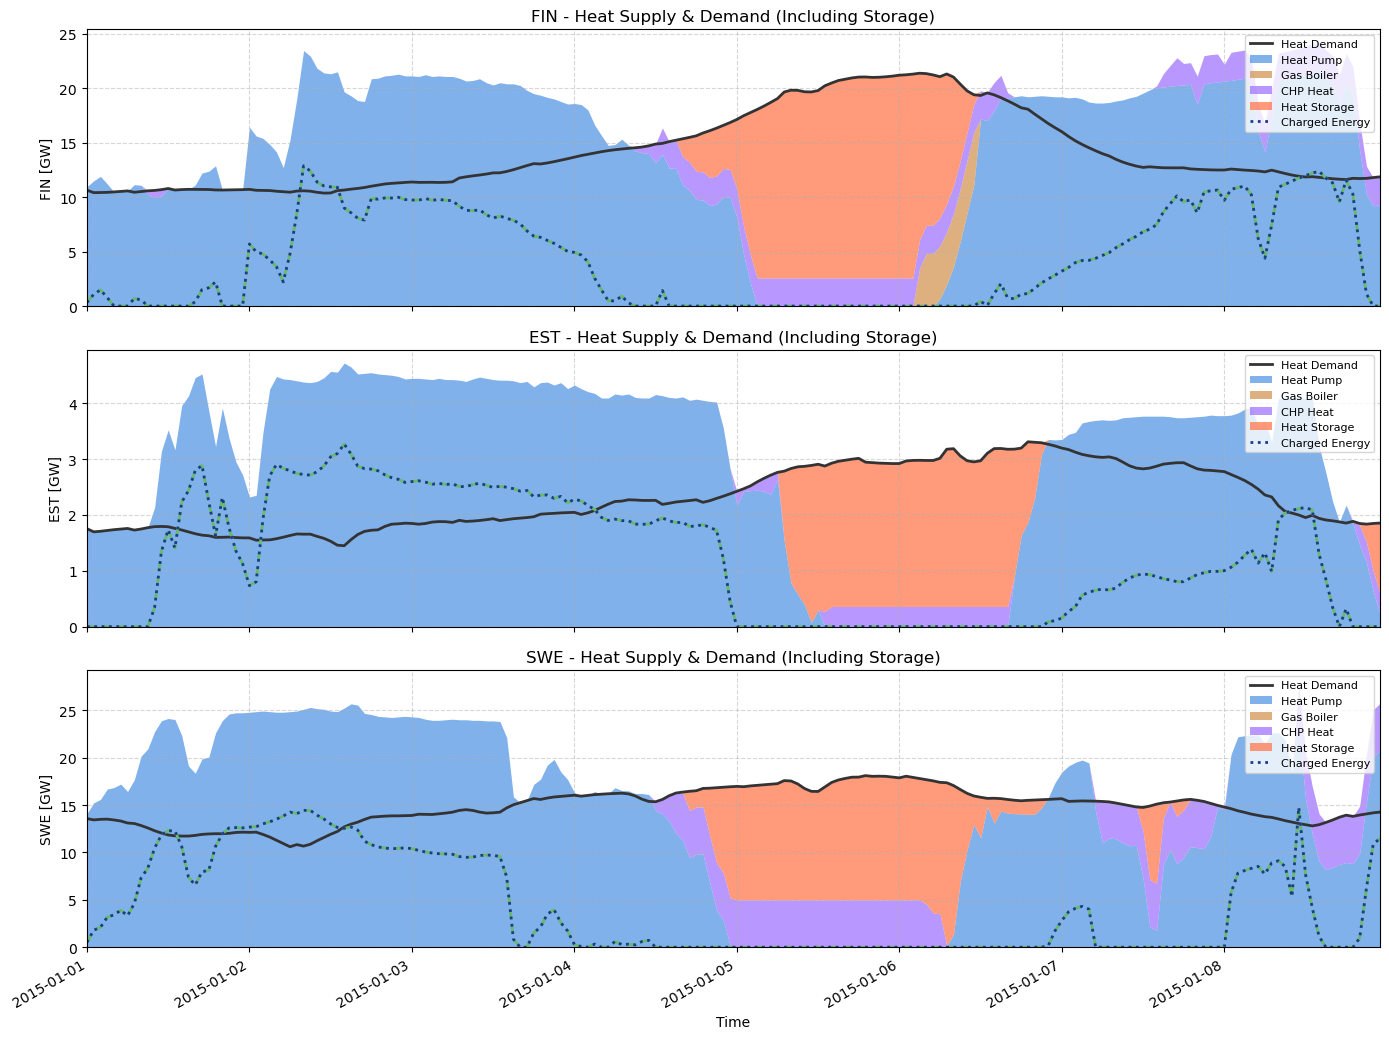

In [77]:
import matplotlib.pyplot as plt

# 🔧 Set time period and countries
start = "2015-01-01"
end = "2015-01-08"
countries = ["FIN", "EST", "SWE"]

colors = {
    "Heat Pump": "#4A90E2",  # Bright Blue
    "Gas Boiler": "#D18F4A",  # Warm Tan
    "CHP Heat": "#9B6DFF",  # Vibrant Lavender
    "Heat Storage": "#FF7043",  # Bright Orange
    "Heat Demand": "#333333",  # Dark Grey
    "Excess Energy": "#66BB6A",  # Fresh Green
    "Charged Energy": "#1E3A8A",  # Midnight Blue
}

# Setup subplots
fig, axs = plt.subplots(len(countries), 1, figsize=(14, 3.5 * len(countries)), sharex=True)

for i, country in enumerate(countries):
    ax = axs[i]
    heat_col = f"heat_load_{country}"

    # Extract heat demand
    heat_demand = network.loads_t.p_set[heat_col].loc[start:end].div(1e3)  # GW

    # Extract heat supply
    heat_pump = -network.links_t.p1.get(f"heat pump_{country}", pd.Series(0, index=heat_demand.index)).loc[start:end].div(1e3)
    gas_boiler = -network.links_t.p1.get(f"gas boiler_{country}", pd.Series(0, index=heat_demand.index)).loc[start:end].div(1e3)
    chp_heat = -network.links_t.p2.get(f"central gas CHP_{country}", pd.Series(0, index=heat_demand.index)).loc[start:end].div(1e3)
    
    # Add heat storage discharge (from state of charge)
    storage_unit = f"{country}_PTES"
    storage_discharge = network.storage_units_t.p_dispatch.get(storage_unit, pd.Series(0, index=heat_demand.index)).loc[start:end].div(1e3)

    # Combine into DataFrame
    df_heat = pd.DataFrame({
        "Heat Pump": heat_pump,
        "Gas Boiler": gas_boiler,
        "CHP Heat": chp_heat,
        "Heat Storage": storage_discharge
    })

    # Calculate Excess Energy
    total_supply = heat_pump + gas_boiler + chp_heat + storage_discharge  # Total energy produced
    excess_energy = total_supply - heat_demand  # Excess energy

    # Calculate Charged Energy (storage charging)
    charge_energy = network.storage_units_t.p_store.get(f"{country}_PTES", pd.Series(0, index=heat_demand.index)).loc[start:end].div(1e3)

    # Plot demand as line
    ax.plot(heat_demand.index, heat_demand.values, label="Heat Demand", color=colors["Heat Demand"], linewidth=2)

    # Plot stacked heat supply
    df_heat.plot.area(ax=ax, alpha=0.7, linewidth=0, color={k: colors[k] for k in df_heat.columns})

    # Plot Excess Energy as line, but without label
    ax.plot(excess_energy.index, excess_energy, color=colors["Excess Energy"], linewidth=2, linestyle="--")

    # Plot Charged Energy as line
    ax.plot(charge_energy.index, charge_energy, label="Charged Energy", color=colors["Charged Energy"], linewidth=2, linestyle=":")

    ax.set_ylabel(f"{country} [GW]")
    ax.set_title(f"{country} - Heat Supply & Demand (Including Storage)")

    # Set x-axis limits to match the start and end of the data
    ax.set_xlim(heat_demand.index[0], heat_demand.index[-1])

    ax.legend(loc="upper right", fontsize=8)
    ax.grid(True, linestyle="--", alpha=0.5)

# Shared x-axis for all subplots
axs[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()


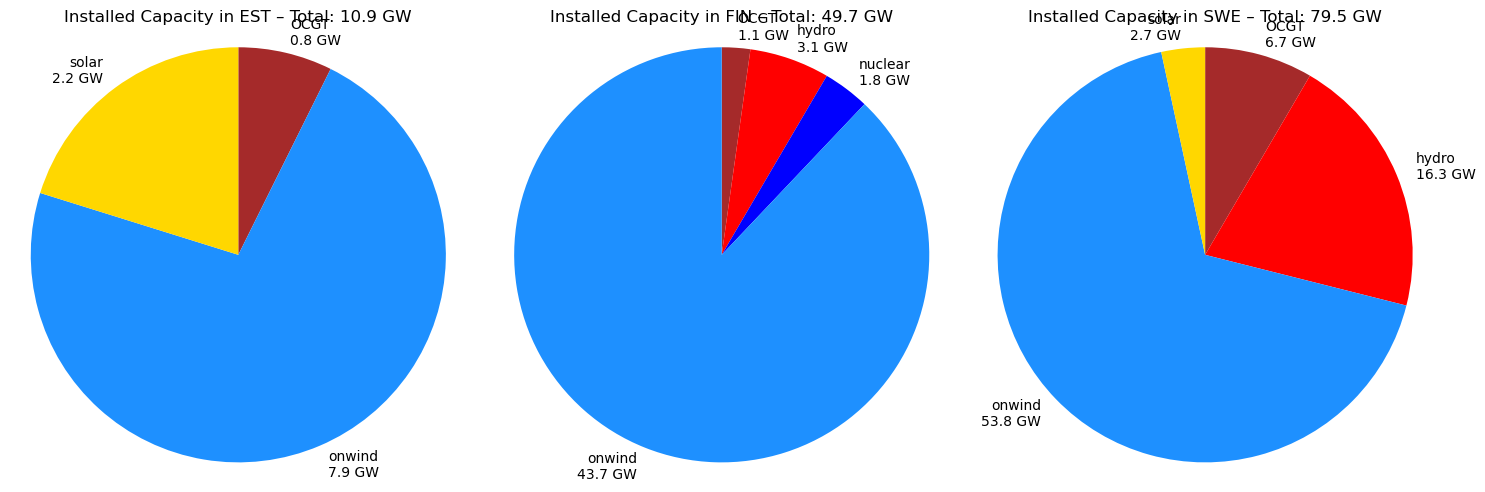

In [78]:
# Group installed capacities by bus and carrier
capacity_data = network.generators.p_nom_opt.groupby(
    [network.generators.bus, network.generators.carrier]
).sum().div(1e3).round(1)  # in GW

# Extract unique country codes
countries = sorted({bus.split("_")[0] for bus in capacity_data.index.get_level_values(0)})

# Plot pie charts
fig, axs = plt.subplots(1, len(countries), figsize=(5 * len(countries), 5))

for i, country in enumerate(countries):
    # Filter data for current country
    country_data = capacity_data.loc[capacity_data.index.get_level_values(0) == f"{country}_el"]
    
    # Filter out zero-capacity entries
    filtered = country_data[country_data > 0]
    
    labels = filtered.index.get_level_values(1)  # technology names
    values = filtered.values
    total_gw = values.sum().round(1)

    colors_used = [network.carriers.at[tech, "color"] if tech in network.carriers.index else "gray" for tech in labels]

    # Create labels showing tech and GW
    label_with_gw = [f"{label}\n{value:.1f} GW" for label, value in zip(labels, values)]

    axs[i].pie(
        values,
        labels=label_with_gw,
        colors=colors_used,
        startangle=90,
        counterclock=False
    )
    axs[i].axis("equal")
    axs[i].set_title(f"Installed Capacity in {country} – Total: {total_gw:.1f} GW")

plt.tight_layout()
plt.show()

In [79]:
H_CO2_price = -network.global_constraints.mu['CO2Limit']
print(H_CO2_price)

469.3493177634453
